# Google Analytics API - Ecommerce Data - Exploratory Data Analysis 

## Table of Contents <a name="top"></a>
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Data Check](#datacheck)
    * [Data Cleaning](#cleaning)
    * [Outliers](#outliers)
* [Defining The Exploratory Functions](#DEF)
    * [Sales Central Tendency](#sct)
    * [Conversion Rate](#cr)
    * [Customer Profile](#cp)
    * [Distribution of Buyers & Non Buyers Behavior](#dist)
    * [Sales Hour](#sh)
    * [Sales Day](#sd)
    * [Transaction Correlation](#tc)
* [Exploration Per Traffic Mediums](#ETM)
 * [Organic](#organic)
 * [Paid Search](#paidsearch)
 * [Direct](#direct)
 * [Social](#social)
 * [Others](#others)
* [Conclusions](#conclusions)
 * [Differences & Patterns](#dp)
 * [Hypotese Test](#ht)
 * [The End](#te)

# Introduction: Business Problem <a name="introduction"></a> 



Having a good understanding about the behavior of the customers will make it easier to find ways to improve the experience online and reduce difficulties to buy online. The longer visitors stay on your site, the more pages they visit and the more actions they take, the more engaged they will be and more likely to buy from you.

This notebook is the first of a series of two. That will be an Exploratory Analysis and the main idea is to try to get different insights of the traffic mediums of ecommerce.

Exploring the transactions, getting insights of the buyers profile, buyer behavior and checking the correlation between our features and transaction.

The second part of that serie we will find the best classification model per traffic medium. You can check the second part clicking here [here](https://www.kaggle.com/erickvarela/ga-api-e-commerce-part-ii-classification/). 


:)



Have fun!







## Data <a name="data"></a>


The data that we will use, was mining from GA API. To get the granular data with the GA API we need to query for multiple dimensions simultaneously, so then every row returned will represent one session. You can [see more at Alex Papageorgioy article](https://www.linkedin.com/pulse/5-steps-get-google-analytics-ready-data-science-papageorgiou/). (Thank you Alex for the explanations)

So, we ended with a data frame that has 565,942 rows and 14 columns. 

The features are:

     0   ga:userType               565942 non-null  object 
     1   ga:dateHour               565942 non-null  int64  
     2   ga:minute                 565942 non-null  int64  
     3   ga:sourceMedium           565942 non-null  object 
     4   ga:operatingSystem        565942 non-null  object 
     5   ga:region                 565942 non-null  object 
     6   ga:pageDepth              565942 non-null  int64  
     7   ga:daysSinceLastSession   565942 non-null  int64  
     8   ga:sessionDurationBucket  565942 non-null  int64  
     9   ga:sessions               565942 non-null  int64  
     10  ga:hits                   565942 non-null  int64  
     11  ga:itemQuantity           565942 non-null  int64  
     12  ga:transactions           565942 non-null  int64  
     13  ga:transactionRevenue     565942 non-null  float64



[See more](https://ga-dev-tools.appspot.com/dimensions-metrics-explorer/) about Dimensions & Metrics at GA-DEV-TOOLS



## Methodology <a name="methodology"></a>

First, we gonna build functions to visualise the **Central Tendency**, **Conversion Rate**, **Buyers Profile**, **Distribution of buyer behavior**, **Transaction Hour**, **Transaction Day of the Month** and **Transaction Correlation**. Once we have done that while we explore full data frame, we will explore all the GA Traffic Medium, checking the performance and looking for patterns and differences between them. Also we're gonna try to find some hypotheses that could improve buyers experiences from each traffic medium on the site.

The functions, we will use Seanborn and Matplotlib the most popular python data visualization libraries.


So, let's get started!


[See more about Medium at support Google](https://support.google.com/analytics/answer/6099206?hl=en)






In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display_html 

In [2]:
df = pd.read_csv('/kaggle/input/google-analytics-api-ecommerce-data/GA_API_Ecommerce_Data_RAW.csv',index_col=0)

# Data Check <a name="datacheck"></a>

In [3]:
# looking for data formats and null values 

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 565942 entries, 0 to 565941
Data columns (total 14 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   ga:userType               565942 non-null  object 
 1   ga:dateHour               565942 non-null  int64  
 2   ga:minute                 565942 non-null  int64  
 3   ga:sourceMedium           565942 non-null  object 
 4   ga:operatingSystem        565942 non-null  object 
 5   ga:region                 565942 non-null  object 
 6   ga:pageDepth              565942 non-null  int64  
 7   ga:daysSinceLastSession   565942 non-null  int64  
 8   ga:sessionDurationBucket  565942 non-null  int64  
 9   ga:sessions               565942 non-null  int64  
 10  ga:hits                   565942 non-null  int64  
 11  ga:itemQuantity           565942 non-null  int64  
 12  ga:transactions           565942 non-null  int64  
 13  ga:transactionRevenue     565942 non-null  f

In [4]:
df.head()

,ga:userType,ga:dateHour,ga:minute,ga:sourceMedium,ga:operatingSystem,ga:region,ga:pageDepth,ga:daysSinceLastSession,ga:sessionDurationBucket,ga:sessions,ga:hits,ga:itemQuantity,ga:transactions,ga:transactionRevenue
0,New Visitor,2019081200,17,google / organic,Windows,State of Rio Grande do Sul,9,0,925,1,1,0,0,0.0
1,New Visitor,2019081200,19,google / organic,Windows,State of Rio Grande do Sul,9,0,925,0,3,0,0,0.0
2,New Visitor,2019081200,21,google / organic,Android,State of Bahia,1,0,0,1,1,0,0,0.0
3,New Visitor,2019081200,22,Instagram / Bio,iOS,State of Sao Paulo,2,0,33,1,2,0,0,0.0
4,New Visitor,2019081200,32,google / organic,Windows,State of Rio Grande do Sul,9,0,925,0,4,0,0,0.0


## Data Cleaning<a name="cleaning"></a>

#### Date Hour
Breaking 'ga:dateHour' in 'ga:day' and 'ga:hour'

In [5]:
## Creating new columns using on 'ga:dateHour'

df['ga:dateHour'] = pd.to_datetime(df['ga:dateHour'],format='%Y%m%d%H',errors='coerce')
df['ga:day'] = [d.day for d in df['ga:dateHour']]
df['ga:hour'] = [d.hour for d in df['ga:dateHour']]

#### Session Duration Bucket to Minutes
Session duration bucket is the total duration of all sessions in seconds. Here we gonna convert for minutes

In [6]:
## Changing Sessiondurationbucket to 'MinutesessionDuration'

df['minutesessionDuration'] = df['ga:sessionDurationBucket']//60

#### Source/Medium to Source and Medium

According to Google:
"Source/Medium is a dimension that combines the dimensions Source and Medium. Examples of Source/Medium include google/organic, example.com/referral, and newsletter9-2014/email"

[See more at: Google Support - Source Medium](https://support.google.com/analytics/answer/6099206?hl=en#:~:text=Source%3A%20the%20origin%20of%20your,%2C%20web%20referral%20(referral).)

In [7]:
df['ga:sourceMedium'].value_counts()

google / organic                      185054
google / cpc                          169036
(direct) / (none)                      93036
l.instagram.com / referral             71812
instagram.com / referral               17496
youtube.com / referral                 16993
Instagram / Bio                         3634
m.facebook.com / referral               3541
bing / organic                           802
accounts.google.com / referral           679
facebook.com / referral                  592
br.search.yahoo.com / referral           590
blog / postblog                          372
googleweblight.com / referral            357
l.facebook.com / referral                300
IGShopping / Social                      291
m.youtube.com / referral                 190
ecosia.org / organic                     160
google.com / referral                    152
t.co / referral                          134
ebit.com.br / referral                   126
accounts.google.com.br / referral         95
web.facebo

We can split 'ga:sourceMedium' in 'source' and 'medium' based on the forward slash in the values. 



Looking closely we can see that there are some inconsistent values and we should replace them. Some sources like  'l.instagram.com / referral', 'Instagram / Bio' and 'instagram.com / referral' have more than one name for the same traffic Source. In the example above, the Medium must be 'Social' but it was listed as 'referral' or 'bio'. Also, there are more than one Medium name for the same medium, such as 'Organic' medium for example.




For organize the Mediums and Sources, we will build lists with the sources / mediums values and then we will use the loc method to create new columns with the name of the Mediums and Sources.




In [8]:
# Source Medium split 
df['source'] = df['ga:sourceMedium'].str.split(' / ').str[0]

In [9]:
df['source'].value_counts()

google                     354090
(direct)                    93036
l.instagram.com             71812
instagram.com               17496
youtube.com                 16993
Instagram                    3634
m.facebook.com               3541
bing                          802
accounts.google.com           679
facebook.com                  592
br.search.yahoo.com           590
blog                          402
googleweblight.com            357
l.facebook.com                300
IGShopping                    291
m.youtube.com                 190
ecosia.org                    160
google.com                    152
t.co                          134
ebit.com.br                   126
accounts.google.com.br         95
web.facebook.com               89
mail.google.com                87
yahoo                          46
g.results.supply               44
sts-sec.lhoist.com             36
outlook.live.com               32
org-search.com                 24
br-nav.com                     16
lm.facebook.co

In [10]:
# medium lists
organic=['google / organic',
 'ecosia.org / organic',
 'yahoo / organic',
 'bing / organic',
 'duckduckgo / organic',
 'google.com / referral',
 'google.com.br / referral',
 'accounts.google.com.br / referral']
 
paidsearch=['google / cpc',
     'cpc / GoogleAds',
     'ads.google.com / referral']
 
social=['Instagram / Bio',
     'instagram.com / referral',
     'm.facebook.com / referral',
     'l.instagram.com / referral',
     'IGShopping / Social',
     'facebook.com / referral',
     'youtube.com / referral',
     'l.facebook.com / referral',
     'm.youtube.com / referral',
     'influenciador / youtube',
     'lm.facebook.com / referral',
     'faceads / linkpatrocinado1'
     'faceads / stories',
     'faceads / lp',
     'pinterest.com / referral',
     'mobile.facebook.com / referral',
     'web.facebook.com / referral',
     'faceads / stories',
     'faceads / linkpatrocinado1']
 
direct=['(direct) / (none)']     

others=['t.co / referral',
    'blog / postblog',
    'outlook.live.com / referral',      
    'br.search.yahoo.com / referral',
    'blog / post',
    'adwords.corp.google.com / referral',
    'accounts.google.com / referral',     
    'mail.google.com / referral',  
    'ebit.com.br / referral',
    'googleweblight.com / referral',
    'qpl-search.com / referral',
    'qo-br.com / referral',
    'g.results.supply / referral',
    'mail1.uol.com.br / referral',
    'baidu.com / referral',
    'br-nav.com / referral',     
    'org-search.com / referral',
    'sts-sec.lhoist.com / referral',
    'bmail1.uol.com.br / referral'
        ]



In [11]:
# loc the mediums

df.loc[df['ga:sourceMedium'].isin(organic),'medium']='Organic'
df.loc[df['ga:sourceMedium'].isin(paidsearch),'medium']='Paid Search'
df.loc[df['ga:sourceMedium'].isin(direct),'medium']='Direct'
df.loc[df['ga:sourceMedium'].isin(social),'medium']='Social'
df.loc[df['ga:sourceMedium'].isin(others),'medium']='Others'

In [12]:
df['medium'].value_counts()

Organic        186314
Paid Search    169042
Social         114971
Direct          93036
Others           2579
Name: medium, dtype: int64

In [13]:
# sources lists

# Social
instagram=['Instagram',
        'l.instagram.com',
       'instagram.com',
       'IGShopping']

facebook=['m.facebook.com',
          'facebook.com',
          'l.facebook.com',
          'web.facebook.com',
          'lm.facebook.com',
          'faceads',
          'mobile.facebook.com']

youtube=['youtube.com',
         'm.youtube.com',
         'influenciador']

pinterest=['pinterest.com']

# Paidsearch
googleAds = ['google',
'ads.google.com',
'cpc' ]

#organic
google=['google.com',
        'accounts.google.com.br',
        'google.com.br']

In [14]:
# loc sources

df.loc[(df['medium']=='Social')&(df['source'].isin(instagram)),'source']='instagram'
df.loc[(df['medium']=='Social')&(df['source'].isin(facebook)),'source']='facebook'
df.loc[(df['medium']=='Social')&(df['source'].isin(youtube)),'source']='youtube'
df.loc[(df['medium']=='Social')&(df['source'].isin(pinterest)),'source']='pinterest'
df.loc[(df['medium']=='Paid Search')&(df['source'].isin(googleAds)),'source']='google ads'
df.loc[(df['medium']=='Organic ')&(df['source'].isin(google)),'source']='google'


In [15]:
df['source'].value_counts()

google                     185054
google ads                 169042
instagram                   93233
(direct)                    93036
youtube                     17193
facebook                     4544
bing                          802
accounts.google.com           679
br.search.yahoo.com           590
blog                          402
googleweblight.com            357
ecosia.org                    160
google.com                    152
t.co                          134
ebit.com.br                   126
accounts.google.com.br         95
mail.google.com                87
yahoo                          46
g.results.supply               44
sts-sec.lhoist.com             36
outlook.live.com               32
org-search.com                 24
br-nav.com                     16
mail1.uol.com.br               15
baidu.com                      13
qo-br.com                       7
qpl-search.com                  7
bmail1.uol.com.br               6
adwords.corp.google.com         4
duckduckgo    

### Dropping and Organizing Columns

* Droping 'ga:dateHour','ga:minute','session','ga:sessionDurationBucket','ga:sourceMedium'
and organizing the columns 

In [16]:
df.columns

Index(['ga:userType', 'ga:dateHour', 'ga:minute', 'ga:sourceMedium',
       'ga:operatingSystem', 'ga:region', 'ga:pageDepth',
       'ga:daysSinceLastSession', 'ga:sessionDurationBucket', 'ga:sessions',
       'ga:hits', 'ga:itemQuantity', 'ga:transactions',
       'ga:transactionRevenue', 'ga:day', 'ga:hour', 'minutesessionDuration',
       'source', 'medium'],
      dtype='object')

In [17]:
cols=['ga:transactions',
 'source',
 'medium',
 'ga:transactionRevenue',
 'ga:itemQuantity',
 'minutesessionDuration',
 'ga:pageDepth',
 'ga:hits',
 'ga:daysSinceLastSession',
 'ga:operatingSystem',
 'ga:region',
 'ga:userType',
 'ga:day',
 'ga:hour',
 ]
df = df[cols]

In [18]:
df.tail()

,ga:transactions,source,medium,ga:transactionRevenue,ga:itemQuantity,minutesessionDuration,ga:pageDepth,ga:hits,ga:daysSinceLastSession,ga:operatingSystem,ga:region,ga:userType,ga:day,ga:hour
565937,0,youtube,Social,0.0,0,42,11,3,0,Android,State of Sao Paulo,Returning Visitor,14,18
565938,0,google ads,Paid Search,0.0,0,1,3,4,0,Android,State of Rio Grande do Sul,Returning Visitor,14,18
565939,0,google ads,Paid Search,0.0,0,13,27,3,0,iOS,State of Minas Gerais,Returning Visitor,14,18
565940,0,google ads,Paid Search,0.0,0,1,3,2,0,Android,State of Rio Grande do Sul,Returning Visitor,14,18
565941,0,google ads,Paid Search,0.0,0,13,27,3,0,iOS,State of Minas Gerais,Returning Visitor,14,18


## Outliers <a name="outliers"></a>

First we will use the describe method to explore the distribution. Second, we will plot the numeric distributions with Boxplot.

In [19]:
# Getting descriptive infos

df.describe()

,ga:transactions,ga:transactionRevenue,ga:itemQuantity,minutesessionDuration,ga:pageDepth,ga:hits,ga:daysSinceLastSession,ga:day,ga:hour
count,565942.000000,565942.000000,565942.000000,565942.00000,565942.000000,565942.000000,565942.000000,565942.000000,565942.000000
mean,0.002126,0.204335,0.013641,19.03359,30.169159,6.816819,0.523504,15.718727,14.983991
std,0.046056,6.901586,0.483758,25.57011,36.740971,5.436881,5.318111,8.651532,5.903094
min,0.000000,0.000000,0.000000,0.00000,0.000000,1.000000,0.000000,1.000000,0.000000
25%,0.000000,0.000000,0.000000,1.00000,3.000000,3.000000,0.000000,8.000000,12.000000
50%,0.000000,0.000000,0.000000,9.00000,14.000000,5.000000,0.000000,16.000000,16.000000
75%,0.000000,0.000000,0.000000,28.00000,44.000000,9.000000,0.000000,23.000000,20.000000
max,1.000000,1698.590000,106.000000,321.00000,219.000000,89.000000,148.000000,31.000000,23.000000


In [20]:
# Percentage of Bounce Rate

pd.DataFrame(df['minutesessionDuration'].value_counts(normalize=True).head())

,minutesessionDuration
0,0.204811
1,0.061441
2,0.049878
3,0.039737
4,0.035970


### Inferences 

There is a highly numbers of zeros in some columns. In 'ga:daysSinceLastSessio', 'ga:itemQuantity', 'ga:revenuePerItem', 'ga:transactionRevenue' the reason is compreensible. But 20% of 'minuteSessionDuration' and 0 'pageDepth' can seem weird.

This could be due to the Bounce Rate. The GA considers a "Bounce" the sessions which the user only viewed a single page and there are no later hits detected. Some times, GA can track events in the load of the page e.g transactions or goals but not the hits.


[See more at: Google Support - Bounce Rate](https://support.google.com/analytics/answer/1009409?hl=en#:~:text=About%20bounce%20rate&text=Bounce%20rate%20is%20single%2Dpage,request%20to%20the%20Analytics%20server.)


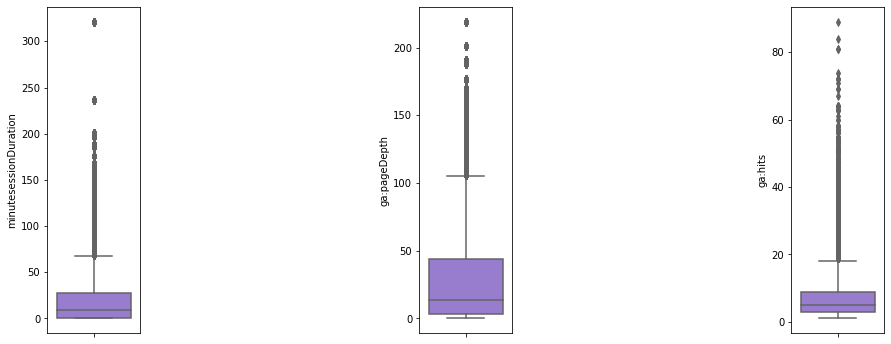

In [21]:
# Numeric columns 
columns_n = ['minutesessionDuration','ga:pageDepth','ga:hits']
df_n = df[columns_n]

# Plotting the distribution

l = df_n.columns.values
ncols = int(len(l))
nrows = 1

fig,ax2d = plt.subplots(nrows,ncols)
fig.set_size_inches(15,6)
fig.subplots_adjust(wspace=3)

ax = np.ravel(ax2d)

for count,i in enumerate(df_n):
    sns.boxplot(y = df_n[i],ax = ax[count],color = 'mediumpurple')

### Inferences

Those metrics above are our main behavior metrics, in this box plot we have a good visualization of the distributions, quartile and outliers. But the most important insight here is, there are a highly number of zeros in "minutesessionDuration". 

To be more specific this notebook will explore the traffic separately. We will see the distribution based on the traffic mediums and sessions with sale and without sales.



Below we will define a function for calculating the Interquartile Range Rule to use ahead.


In [22]:
def Iqr(df):
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    return IQR,Q3

# Defining The Exploratory Functions <a name="DEF"></a>

## Sales Central Tendency <a name="sct"></a>


The function below will create a table with mean, median, mode and total of Item Quantity, Transactions and Transaction Revenue. 

In [23]:
def Sales_Central_Tendency(df):
    
    #DF total sales
    
    sales = df[df['ga:transactionRevenue']!=0]
    
    #Creating the table
    
    total_sales = {' ': ['ga:itemQuantity',
                      'ga:transactions', 
                      'ga:transactionRevenue'
                     ],
                'Mean': [sales['ga:itemQuantity'].mean(), 
                         sales['ga:transactions'].mean(), 
                         '%.2f' %sales['ga:transactionRevenue'].mean()
                         ],
              'Median': [sales['ga:itemQuantity'].median(), 
                          sales['ga:transactions'].median(),       
                          sales['ga:transactionRevenue'].median()
                         ],
                'Mode': [sales['ga:itemQuantity'].mode()[0], 
                         sales['ga:transactions'].mode()[0],       
                         sales['ga:transactionRevenue'].mode()[0]
                         ],
               'Total': [sales['ga:itemQuantity'].sum(), 
                          sales['ga:transactions'].sum(),        
                        '%.2f' % sales['ga:transactionRevenue'].sum()
                         ]
                    }
     
    total_sales = pd.DataFrame(total_sales, columns = [' ','Mean','Median','Mode','Total']).set_index(' ')
    
    
    return total_sales

In [24]:
# Sales central tendency with outliers

Sales_Central_Tendency(df)

,Mean,Median,Mode,Total
,,,,
ga:itemQuantity,6.40565,5.00,1.00,7706
ga:transactions,1,1.00,1.00,1203
ga:transactionRevenue,96.13,70.96,30.96,115641.80


## Conversion Rate <a name="cr"></a>

That function will count all sessions of the data frame, calculate the percentile of session without transaction and with transactions.

In [25]:
def Conversion_Rate(df):
    print(len(df),'Sessions in this period')
    print('Non-transactions', round(df['ga:transactions'].value_counts()[0]/len(df) * 100,2), '% ')
    print('Transactions', round(df['ga:transactions'].value_counts()[1]/len(df) * 100,2), '% ')

In [26]:
Conversion_Rate(df)

565942 Sessions in this period
Non-transactions 99.79 % 
Transactions 0.21 % 


## Inferences

We are dealing with a very unbalanced data frame. Just 0.21% of the sessions had a transaction.

## Customer Profile <a name="cp"></a>

With the next two functions we will have a good visualisation of the customer's profile. Answering the questions about the buyer:

* What are the top 5 operating systems they use.

* What are the top 10 regions of the users.

* In DFs with more than one source or medium we also will plot them.

**Feature Reduction**

First the function drops information obtained after the transaction as 'ga:itemQuantity' and 'ga:transactionRevenue' to avoid data leakage. Then, the function will reduce the columns 'ga: region' for the 10 most common and 'ga: operatingSystem' for the 5 most common. The other values from 'ga: region' and 'ga: operatingSystem' will be summed and renamed as '(Others)'.



In [27]:
def Feature_Reduction(df):
        
    drop_elements=['ga:itemQuantity','ga:transactionRevenue'] 
    df = df.drop(drop_elements, axis = 1)
    
        # Top 10 Regions
    
    all_states = pd.DataFrame(df['ga:region'].value_counts())
    states = all_states.head(10)
        ##Other states
    all_others_states = all_states[~all_states['ga:region'].isin(list(states['ga:region']))].reset_index()
    others_states = pd.DataFrame(all_others_states['index'])
        ##Changing other regions per '(Others)'
    df.loc[df['ga:region'].isin(others_states['index']),'ga:region']='(Others)'


        #Top 5 operatingSystem 
        
    all_operatingSystem = pd.DataFrame(df['ga:operatingSystem'].value_counts())
    operatingSystem = all_operatingSystem.head()
        ##Other operatingSystem 
    all_others_operatingSystem = all_operatingSystem[~all_operatingSystem['ga:operatingSystem'].isin(list(operatingSystem['ga:operatingSystem']))]
    others_operatingSystem = list(all_others_operatingSystem['ga:operatingSystem'])
        ##Changing other operatingSystem per '(Others)'
    df.loc[df['ga:operatingSystem'].isin(others_operatingSystem),'ga:operatingSystem']='(Others)'
    
    
    df=df.reset_index(drop=True)
    
    return df

**Buyer Profile**

The second function, will get all the sessions with transaction, will check if the DF have more than one 'Medium' and 'Source'. If so, it will be included in the features list to plot and finally, will run a for loop to plot the categorical values as a bar plot normalized for each column of our DF.


In [28]:
def Buyer_Profile(df):
    
    # Transaction = 1
    sales = df[df['ga:transactions']!=0]
    
    sales = Feature_Reduction(sales)
    
    # Checking if there is more than 1 channel Groupping in the DF
    
    if len(sales['medium'].value_counts()) > 1:
        sales = sales[['ga:transactions','ga:operatingSystem','ga:region','source','medium']]
    elif len(sales['source'].value_counts()) == 1:
        sales = sales[['ga:transactions','ga:operatingSystem','ga:region']]
    else:
        sales = sales[['ga:transactions','ga:operatingSystem','ga:region','source']]
    
    # Prepareing the df to plot the categorical variables of the buyers
    
    catdf = sales.columns[1::]
    
    nrows = 1
    ncols = len(catdf)

    fig,ax2d = plt.subplots(nrows,ncols)
    fig.set_size_inches(30,5)
    fig.subplots_adjust(wspace=0.2)

    ax=np.ravel(ax2d)

    for count,i in enumerate(catdf):
            plot1=sns.barplot(x=i,
                y='ga:transactions',
                hue='ga:transactions',
                color='#4B0082',
                data=sales,
                ax=ax[count],
                estimator=lambda x: len(x) / len(df) * 100)
    
            plot1.set_xticklabels(plot1.get_xticklabels(),rotation=90)
            plot1.set(ylabel = "Transaction Frequencie")
            plot1.legend().remove()
        

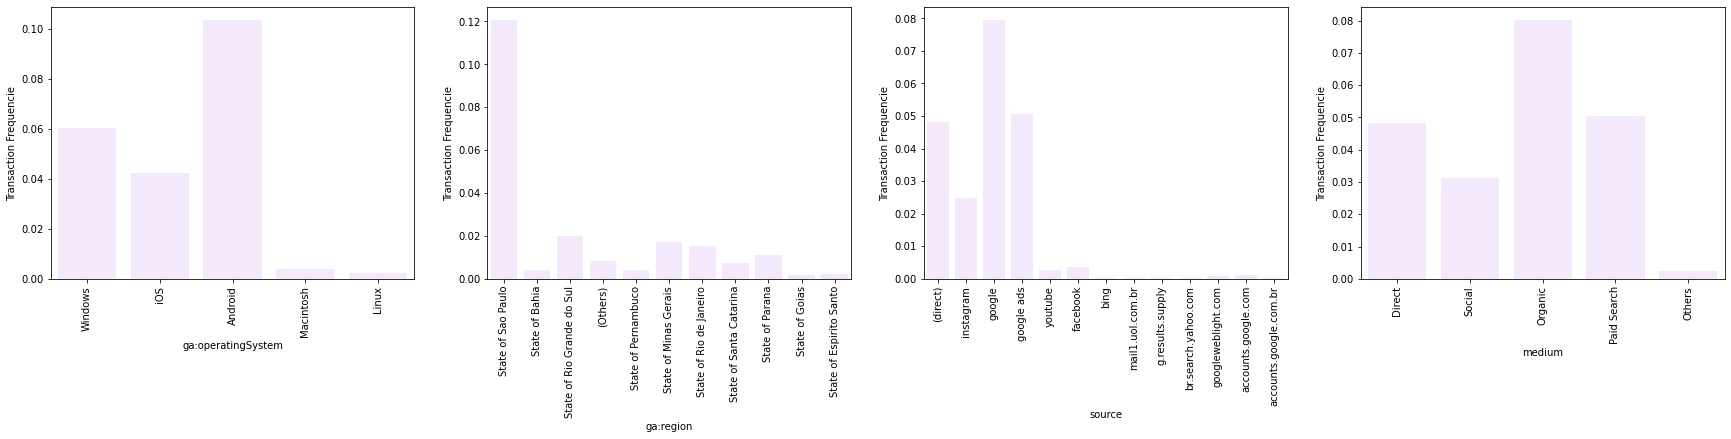

In [29]:
Buyer_Profile(df)

#### Inferences

Answering the questions;

* More than 10% of the sales came from Android operating System.

* 12% of the sales came from the State of São Paulo.

* Almost 0.8% of the sales came from Google sources.

* Approximately 0.8% of the sales came from Organic Medium.


## Distribution of Buyers & Non Buyers Behavior <a name="dist"></a>

This function compares the behavior metrics' minutesessionDuration',' ga: pageDepth ' and 'ga: hits' of the sessions with sale and the sessions without sales.
 * Will to split the data frame in Sales where 'transaction' !=0 and non_sales where 'transaction' == 0.
 * After that, we will call the function IQR to return the IQR and Q3 of boths DF to remove the higher outliers from 'minutesessionDuration','ga:pageDepth' and 'ga:hits'. After that, remove the zeros as well.
 * Also, will find the middle 75% of the behavior metrics, which is between the 12.5th percentile and the 87.5th percentile from each data.
 * So then will run a for loop to plot the distribution of each metrics normalized of both DFs sales and non_sales.


In [30]:
def Behavior_Dist(df):  
    
    #spliting the data
    sales = df[df['ga:transactions']!=0]
    non_sales = df[df['ga:transactions']==0]
    
    behavior=['minutesessionDuration','ga:pageDepth','ga:hits']
    
    sales = sales[behavior]
    non_sales = non_sales[behavior]
    
    
    #Calculing the Interquantilerange
        
    for count,i in enumerate(behavior):
        Q1 = sales[behavior[count]].quantile(0.25)
        Q3 = sales[behavior[count]].quantile(0.75)
        IQR = Q3 - Q1
        #Apling the 1.5 rule for higer out liers
        sales = sales[~(sales[behavior[count]] > (Q3 + 1.5 * IQR))]
    
    sales = sales[sales['minutesessionDuration']>0]   
    
    for count,i in enumerate(behavior):
        Q1 = non_sales[behavior[count]].quantile(0.25)
        Q3 = non_sales[behavior[count]].quantile(0.75)
        IQR = Q3 - Q1
        #Apling the 1.5 rule for higer out liers
        non_sales = non_sales[~(non_sales[behavior[count]] > (Q3 + 1.5 * IQR))]
                
    non_sales = non_sales[non_sales['minutesessionDuration']>0]   
    
    
    non_sales = non_sales.add_prefix("non_sale ")
    sales = sales.add_prefix("sale ")

    # For loop to plot the distribution both dfs
    
    l = sales.columns.values

    nrows = 2
    ncols = int(len(l))

    fig,ax2d = plt.subplots(nrows,ncols)
    fig.set_size_inches(20,10)
    fig.subplots_adjust(wspace=0.4)

    ax=np.ravel(ax2d)
    
    #sale_dist_=pd.DataFrame()
    lst=[]
    lst2=[]
    columns = [' ','Mean','Median','Mode','IQR','12.5th middle','87.5th middle']
    
    for count,i in enumerate(sales):
        sns.distplot(sales[i], kde=True, ax=ax[count], color='#DAB5F8')
        sns.distplot(non_sales["non_"+i], kde=True, ax=ax[count+ncols], color='#F5AE33')
    
        lst.append([i,sales[i].mean(),sales[i].median(),sales[i].mode()[0],Iqr(sales[i])[0],
                            sales[i].quantile(0.5 - 0.75/2),sales[i].quantile(0.5 + 0.75/2)])
        
        lst2.append(["non_"+i,non_sales["non_"+i].mean(),non_sales["non_"+i].median(),non_sales["non_"+i].mode()[0],
                           Iqr(non_sales["non_"+i])[0],non_sales["non_"+i].quantile(0.5 - 0.75/2),non_sales["non_"+i].quantile(0.5 + 0.75/2)])
                                
        sale_dist = pd.DataFrame(lst,columns=columns).set_index(' ')
        non_sale_dist = pd.DataFrame(lst2,columns=columns).set_index(' ')
        
    return sale_dist,non_sale_dist             


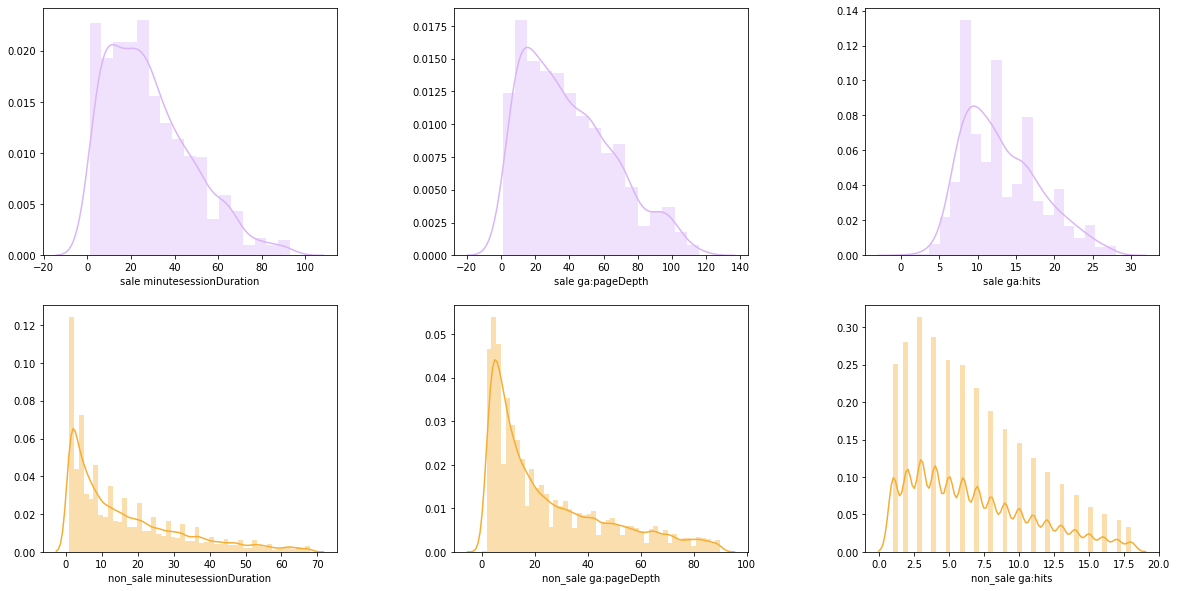

In [31]:
full_sale_dist, full_non_sale_dist = Behavior_Dist(df)

In [32]:
def two_tables(df1,df2):
    df1_styler = df1.style.set_table_attributes("style='display:inline'").set_caption('Sale')
    df2_styler = df2.style.set_table_attributes("style='display:inline'").set_caption('Non Sale')
    
    display_html(df1_styler._repr_html_()+df2_styler._repr_html_(), raw=True)

In [33]:
two_tables(full_sale_dist,full_non_sale_dist)

,Mean,Median,Mode,IQR,12.5th middle,87.5th middle
,,,,,,
sale minutesessionDuration,28.427793,25.000000,28,28.000000,7.000000,52.000000
sale ga:pageDepth,39.683924,35.000000,7,39.000000,10.000000,72.000000
sale ga:hits,13.114441,12.000000,10,7.000000,8.000000,19.000000
,Mean,Median,Mode,IQR,12.5th middle,87.5th middle
,,,,,,
non_sale minutesessionDuration,16.208755,11.000000,1,20.000000,2.000000,36.000000
non_sale ga:pageDepth,24.686496,16.000000,3,30.000000,4.000000,55.000000
non_sale ga:hits,6.662899,6.000000,3,6.000000,2.000000,12.000000


#### Inferences

From each metric; 

* Minute Session Duration

    * Sales are usually between 0 and 90. The middle 75% percentile are between 7 and 52.

    * Non sales are usually between 0 and 70. The middle 75% percentile are between 2 and 36.

* PageDepth

    * Sales are usually between 0 and 120. The middle 75% percentile are between 10 and 72.

    * Non are usually between 0 and 90. The middle 75% percentile are between 4 and 55.
* Hits

    * Sales are usually between 5 and 27. The middle 75% percentile are between 8 and 19.

    * Non sales are usually between 0 and 17. The middle 75% percentile are between 2 and 12.

    




                        

## Sales Hour <a name="sh"></a>

That function will show two plots, the first one will be a Heatmap that shows what hour we got the higher number of transactions. The second one is a regression plot that will help us to visualise the linear relationships between the number of transactions and the hour of the day.


In [34]:
def Transaction_Hour_Plot(df):
    # Df with the hour of transaction
    sales = df[df['ga:transactions']!=0]
    df2=df[df['ga:transactions']!=0]
    print(df2['ga:transactions'].corr(df['ga:hour']))
    transaction_hour = sales[['ga:hour','ga:transactions']]
    transaction_hour = transaction_hour.groupby(['ga:hour'],as_index=False).sum().sort_values('ga:hour',
                                                                                  ascending=True).set_index('ga:hour')
    # Plot the heatmap
    fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(30,10)) 
    sns.heatmap(transaction_hour.T,cmap = "Purples", ax=ax1, linewidths=.2 )
    
    # The dependent variable is denoted "Y" and the independent variables are denoted by "X"
    sns.regplot(y = transaction_hour.reset_index().columns[1],
                x = transaction_hour.reset_index().columns[0],
                data = transaction_hour.reset_index(), ax=ax2, color='#4B0082')
    

nan


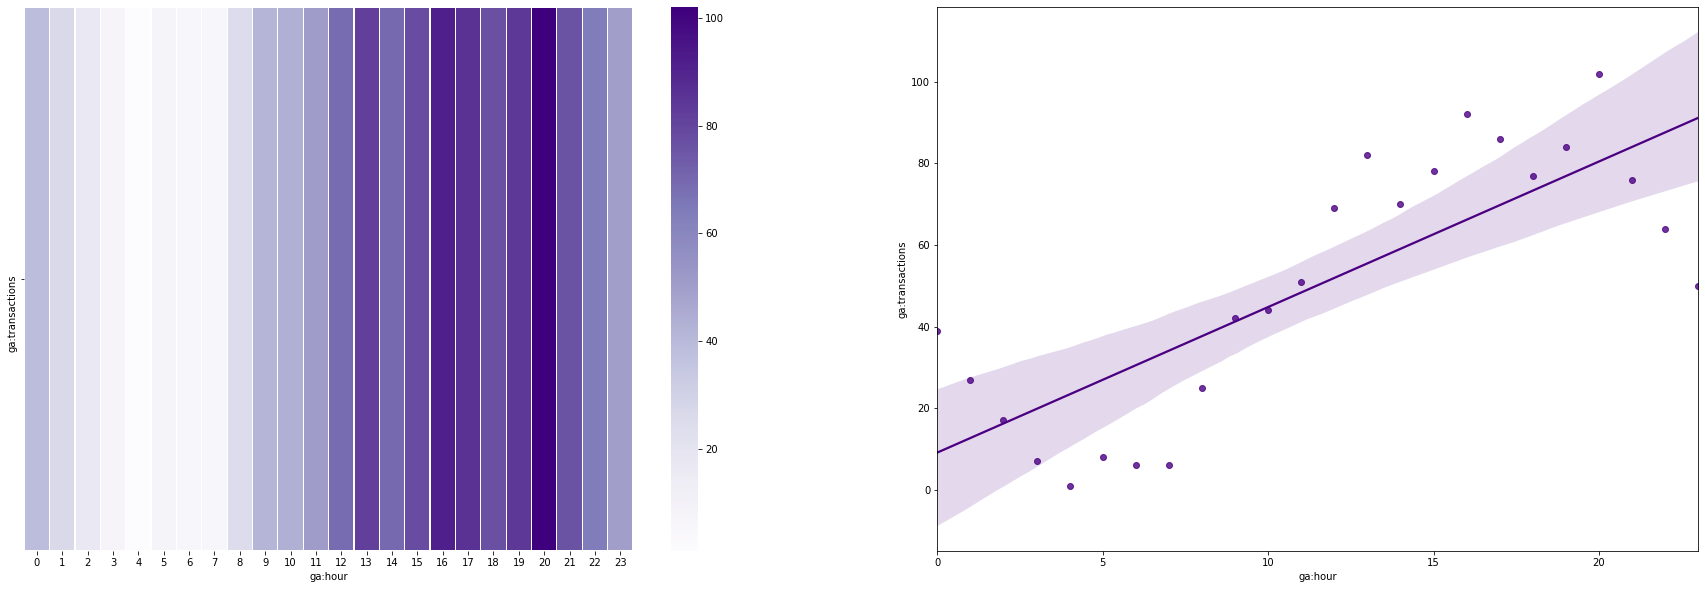

In [35]:
Transaction_Hour_Plot(df)

#### Inferences

The higher number of transactions happen between 12h and 21h. Also we can say that there is a relatively strong positive linear relationship.


## Sales Day <a name="sd"></a>


Here we will do the same thing as above, however the first plot will be a Heat Map that shows what day we got the higher number of transactions. The second one is a regression plot that will help us to visualise the linear relationships between the number of transactions and the day of the month.






In [36]:
def Transactions_Day_Plot(df):

    # df with days of transaction
    sales = df[df['ga:transactions']!=0]
  
    transaction_day = sales[['ga:day','ga:transactions']]
    transaction_day = transaction_day.groupby(['ga:day'],as_index=False).sum().sort_values('ga:day',
                                                                                   ascending=True).set_index('ga:day')
    
    #plot
    fig, (ax1 ,ax2) = plt.subplots(1, 2, figsize=(20,7))         

    sns.heatmap(transaction_day,cmap = "Purples", ax=ax1, linewidths=.2 )
    
    sns.regplot(y = transaction_day.reset_index().columns[1],
                x = transaction_day.reset_index().columns[0],
                data = transaction_day.reset_index(), ax=ax2, color='#4B0082')

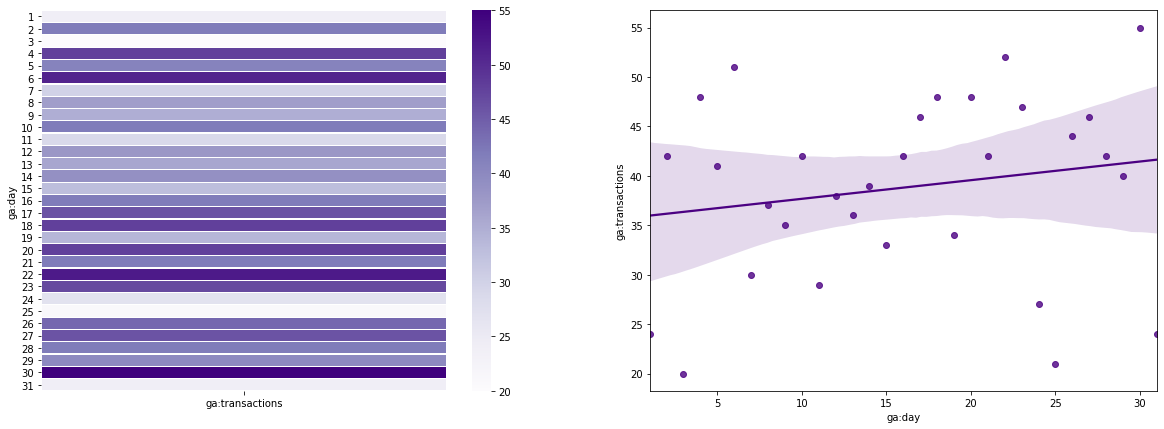

In [37]:
Transactions_Day_Plot(df)

#### Inferences

The higher number of transactions happen at the end of the month. Doing a quick analysis, it could be a counter-intuitive statement. Once that payment of Brazilians monthly salary is paid until the 5th working day of the month.


Also, we can say that there is a weak positive linear relationship.


## Transaction Correlation <a name="tc"></a>

That function will plot a vertical bar plot which is a nice way to visualise the Pearson Correlation Coefficient (PCC). We can easily see the positives and negative P-value. Also we will drop the outliers of the behavior metrics and the 'ga:day' and 'ga:hour' columns.


In [38]:
def Transaction_Corr(df):
    
    drop_elements = ['ga:day','ga:hour']
    
    behavior=['minutesessionDuration','ga:pageDepth','ga:hits']
   

    #Calculing the Interquartile Range
        
    for count,i in enumerate(behavior):
        Q1 = df[behavior[count]].quantile(0.25)
        Q3 = df[behavior[count]].quantile(0.75)
        IQR = Q3 - Q1
        #Apling the 1.5 rule for higher outliers
        df_without = df[~(df[behavior[count]] > (Q3 + 1.5 * IQR))]
    
    df = df_without[df_without['minutesessionDuration']>0]   
    
    ## drop sources columns
    for columns in df:
        if columns[:6]=='source':
            drop_elements.append(columns)
        else:
            pass
    
    df = df.drop(drop_elements, axis = 1)
    
    
    corr_df = pd.DataFrame(df.corr()['ga:transactions']).sort_values(['ga:transactions'],ascending=False)[1:]
    plt.figure(figsize=(10,10))
    plt.title('Feature Correlation with ga:transactions', fontdict={'fontweight':'bold'})
    sns.barplot(x ='ga:transactions',y = corr_df.index,data = corr_df ,color='#DAB5F8')


## Preparation for the Correlations Analysis

Before we start to analysis the correlations in our DFs, we gonna copy the Df, call the Preparation Function to get the top 10 'regions' and top 5 'operatingSystem'. After that, convert categorical variables into dummy/indicator variables.


In [39]:
# Preparation

df_p = df.copy()

df_p = Feature_Reduction(df_p)

df_p = pd.get_dummies(df_p)

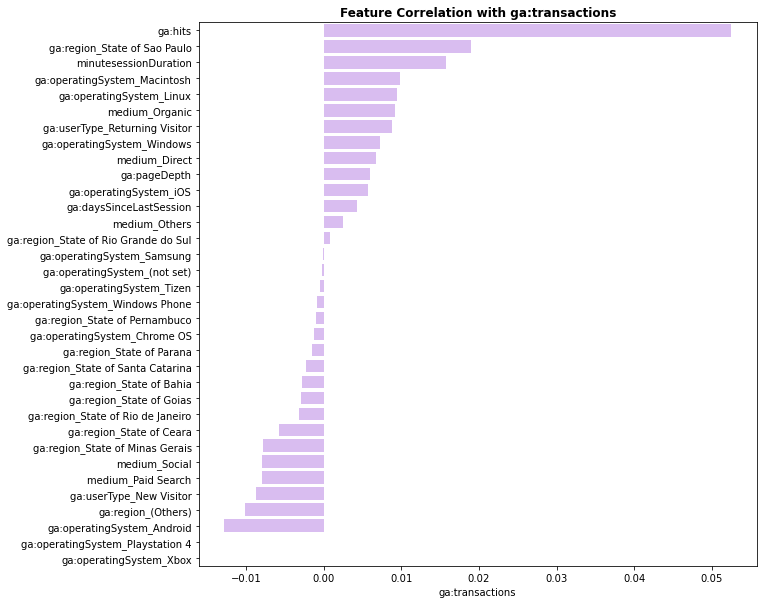

In [40]:
Transaction_Corr(df_p)

### Inferences

Basically we can infer from this graph that Hits, São Paulo and Minutes Session Duration has the stronger positive correlation. Also we can see that returning visitors, Linux, Macintosh and Windows Operating System are positive correlation as well. So we can say that desktop devices have a positive correlation with the transaction.



On the other hand, new visitors, visitors from Other regions and Android operating system have the stronger negative correlation.


## Full DF - Summary Overview





**Central Tendency** - In average the **buyers** used to buy 6 items, do 1 transaction per session and the average transaction revenue is 96.13. Total sales of this period is 115,641.80



**Conversion Rate** - Of the 565,942 sessions. 0.21 % are Transactions. 



**Buyers Profile** - Most of the **buyers** used Android, are from São Paulo and getting to the  website from a Google source, organic medium.



**Distribution of buyer behavior** - The middle 75% of **buyers** session used to spend 7 and 52 minutes on the site, used to visit between 10 and 72 pages on the web site. The **buyers** used to do between 8 and 19 hits on the website. 



The middle 75% of **non-buyers** session used to spend 2 and 36 minutes on the site, used to visit between 4 and 55 pages on the web site. The **non-buyers** used to do between 2 and 12 hits on the website. 



So, we can say that, the middle 75% of **Non-buyers** session are close but smaller than the **buyers** session.



**Transaction Hour** - The higher number of transactions happened between 12h and 21h.



**Transaction Day of the Month** - The higher number of transactions happened in the second half of the month.



**Correlations Analysis** - We can infer from this graph that Hits, São Paulo and Minutes Session Duration has the stronger positive correlation. Also we can see that returning visitors, Linux, Macintosh and Windows Operating System are positive correlation as well. So we can say that desktop devices have a positive correlation with the transaction.

On the other hand, Android users, visitors from Others Eegions and new visitors have the stronger negative correlation.


# Exploration Per Traffic Mediums  <a name="ETM"></a>

Now that we already have our functions and an idea of what kind of inferences we can get, we're gonna split the DF in the different types of Medium. So then, we will see the differences and pattern between the traffic Mediums.


In [41]:
df_organic = df[df['medium']=='Organic']
df_paidsearch = df[df['medium']=='Paid Search']
df_direct = df[df['medium']=='Direct']
df_social = df[df['medium']=='Social']
df_others = df[df['medium']=='Others']

# Traffic Medium - Organic <a name="organic"></a>

In [42]:
Sales_Central_Tendency(df_organic) 

,Mean,Median,Mode,Total
,,,,
ga:itemQuantity,5.49559,4.00,1.00,2495
ga:transactions,1,1.00,1.00,454
ga:transactionRevenue,86.30,67.84,50.84,39178.35


In [43]:
Conversion_Rate(df_organic)

186314 Sessions in this period
Non-transactions 99.76 % 
Transactions 0.24 % 


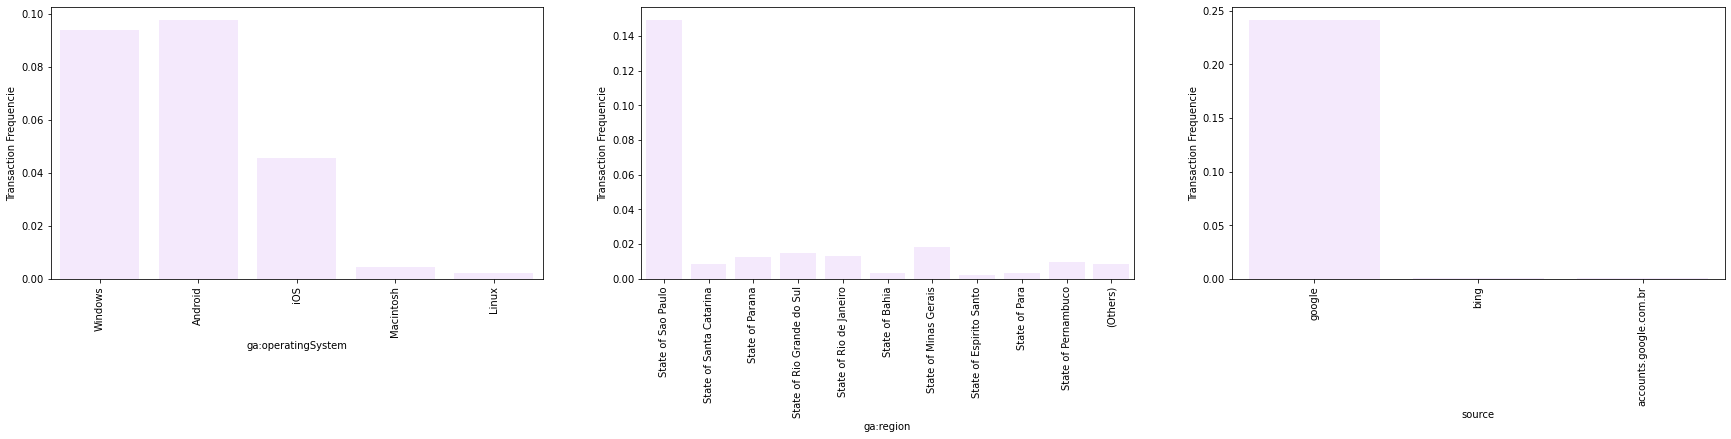

In [44]:
Buyer_Profile(df_organic)

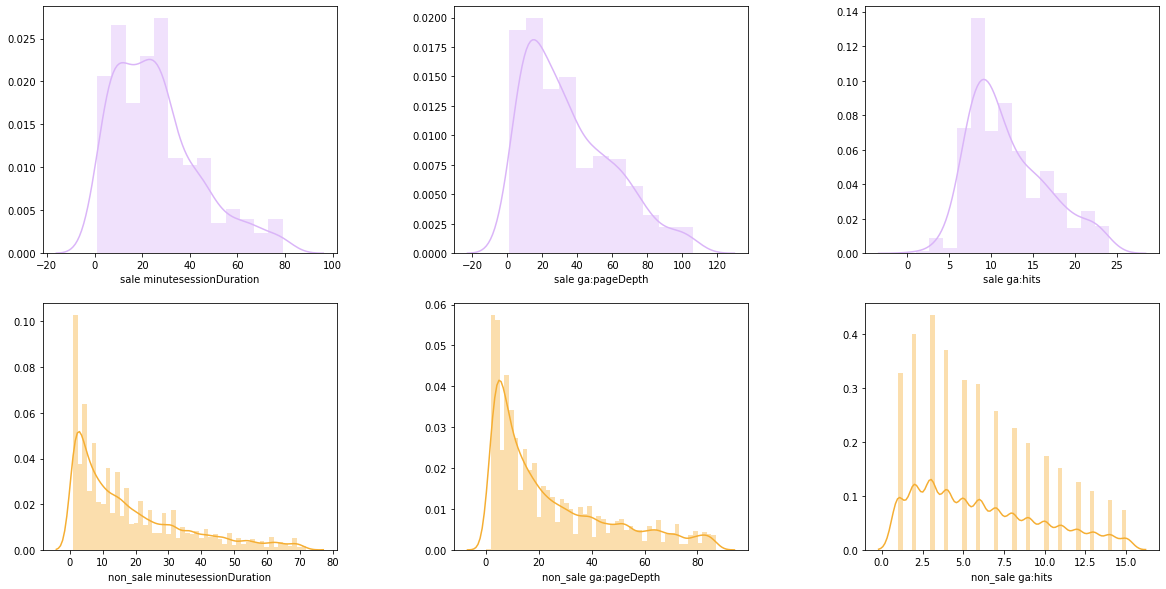

In [45]:
o_sale_dist, o_non_sale_dist = Behavior_Dist(df_organic)

In [46]:
two_tables(o_sale_dist,o_non_sale_dist)

,Mean,Median,Mode,IQR,12.5th middle,87.5th middle
,,,,,,
sale minutesessionDuration,25.919048,23.000000,28,24.250000,7.000000,46.000000
sale ga:pageDepth,35.135714,28.500000,7,38.250000,9.000000,68.000000
sale ga:hits,12.002381,11.000000,10,6.250000,7.000000,18.000000
,Mean,Median,Mode,IQR,12.5th middle,87.5th middle
,,,,,,
non_sale minutesessionDuration,17.963023,12.000000,1,22.000000,2.000000,40.000000
non_sale ga:pageDepth,24.422750,16.000000,3,30.000000,4.000000,55.000000
non_sale ga:hits,6.024898,5.000000,3,6.000000,2.000000,11.000000


nan


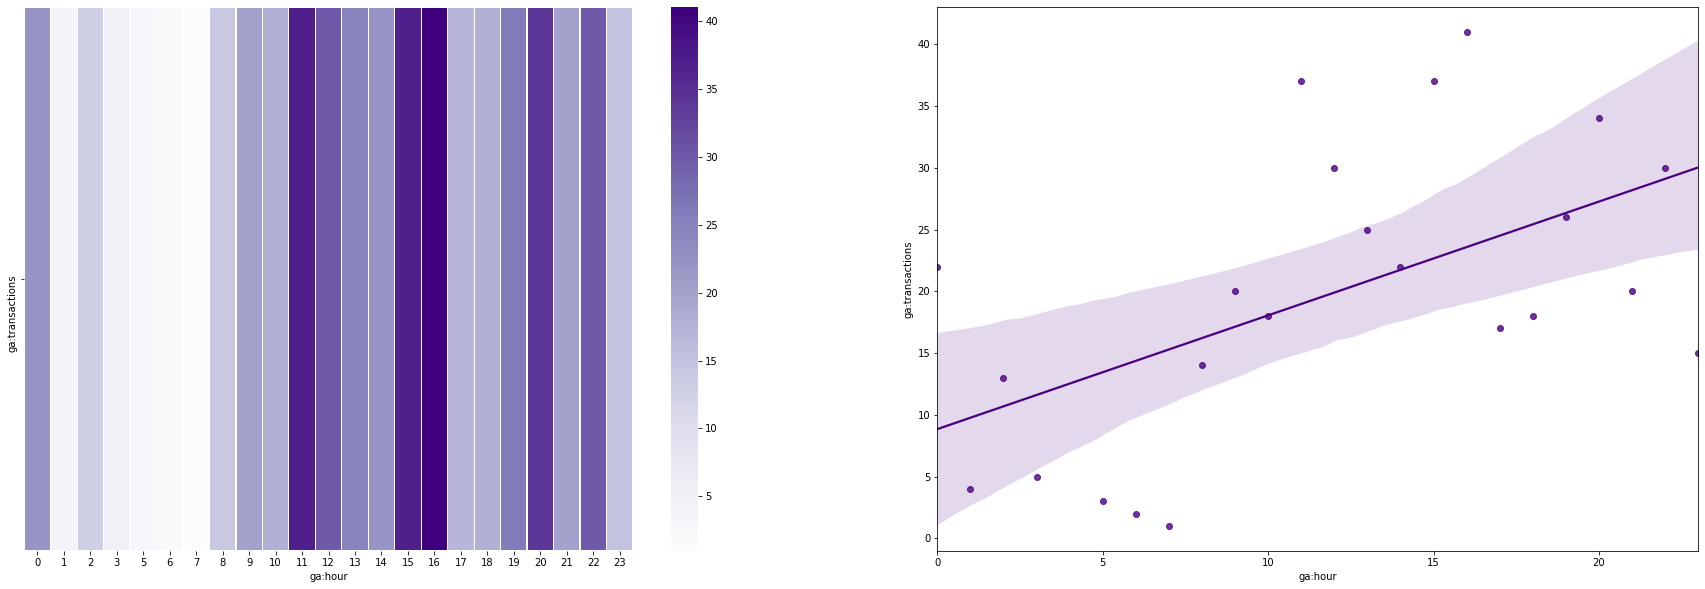

In [47]:
Transaction_Hour_Plot(df_organic)

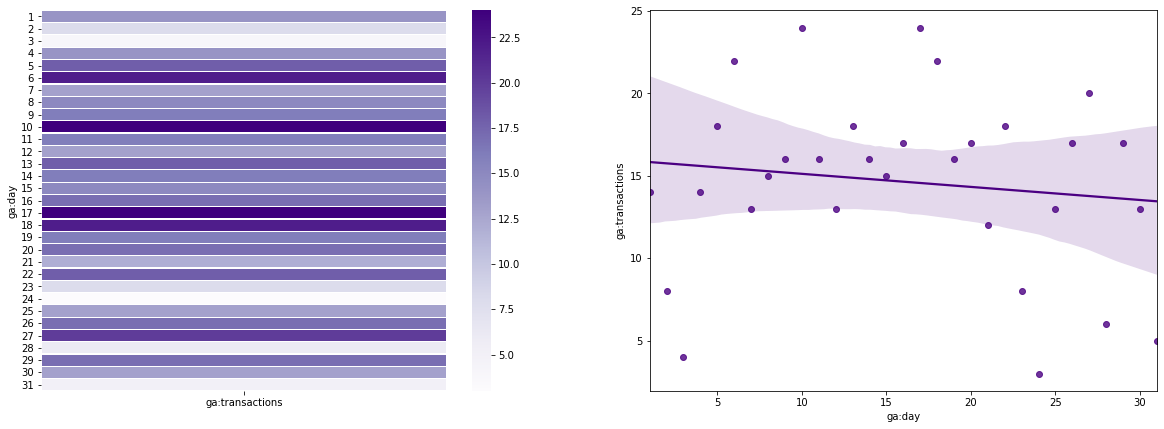

In [48]:
Transactions_Day_Plot(df_organic)

In [49]:
df_organic_p = df_organic.copy()

df_organic_p = Feature_Reduction(df_organic_p)

df_organic_p = pd.get_dummies(df_organic_p)

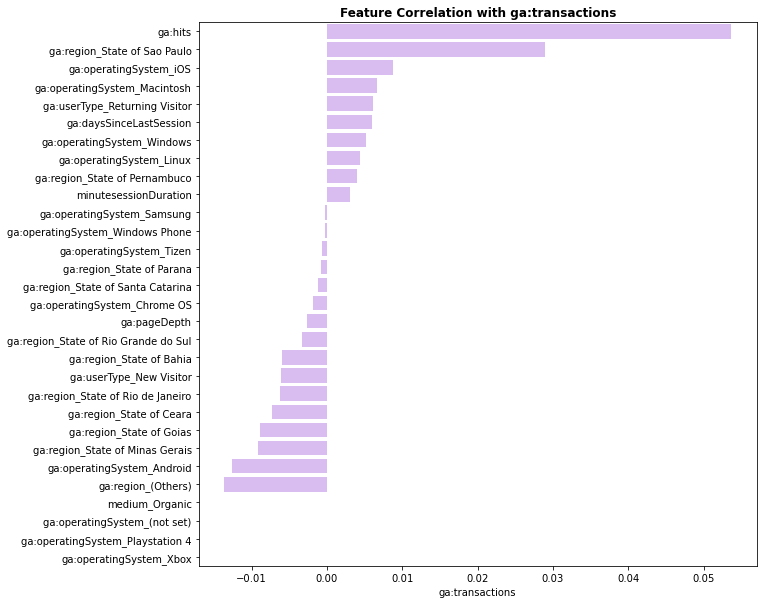

In [50]:
Transaction_Corr(df_organic_p)

## Organic - Summary Overview





**Central Tendency** - In average the **buyers** used to buy 5 items, do 1 transaction per session and the average transaction revenue is 86.30. Total sales of this period is 39,178.35



**Conversion Rate** - Of the 186,314 sessions. 0.24 % are Transactions.



**Buyers Profile** - Most common operating system of the **buyers** is Android followed by Windows operating system IOS users got third place. The majority are from São Paulo.


**Distribution of buyer behavior** - The middle 75% of **buyers** session used to spend 7 and 46 minutes on the site, used to visit between 9 and 68 pages on the web site. The **buyers** used to do between 7 and 18 hits on the website.



The middle 75% of **Non-buyers** session are close but lower than the **buyers** session.



**Transaction Hour** - The higher number of transactions happened between 11h and 22h.



**Transaction Day of the Month** - The number of transactions are very well distributed in the days of the month.



**Correlations Analysis** -  Hits, São Paulo have the stronger positive correlation. Also we can see that IOS users, Macintosh users, Returning Visitors, Days Since the Last Session, Windows and Linux are positive correlation as well. So we can say that the desktop devices have a small but positive correlation with the transaction.

On the other side, visitors from Others Regions, Android users and Minas Gerais have the stronger negative correlation.








# Traffic Medium - Paidsearch <a name="paidsearch"></a>

In [51]:
Sales_Central_Tendency(df_paidsearch)

,Mean,Median,Mode,Total
,,,,
ga:itemQuantity,6.87762,5.00,4.00,1967
ga:transactions,1,1.00,1.00,286
ga:transactionRevenue,108.82,75.03,186.14,31121.57


In [52]:
Conversion_Rate(df_paidsearch)

169042 Sessions in this period
Non-transactions 99.83 % 
Transactions 0.17 % 


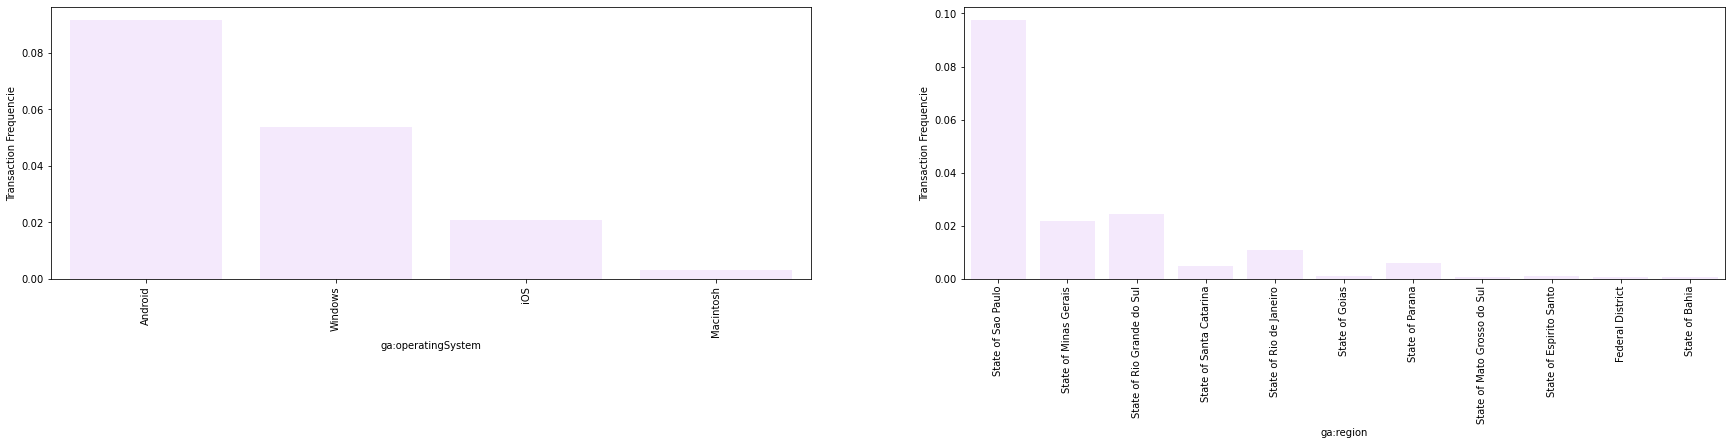

In [53]:
Buyer_Profile(df_paidsearch)

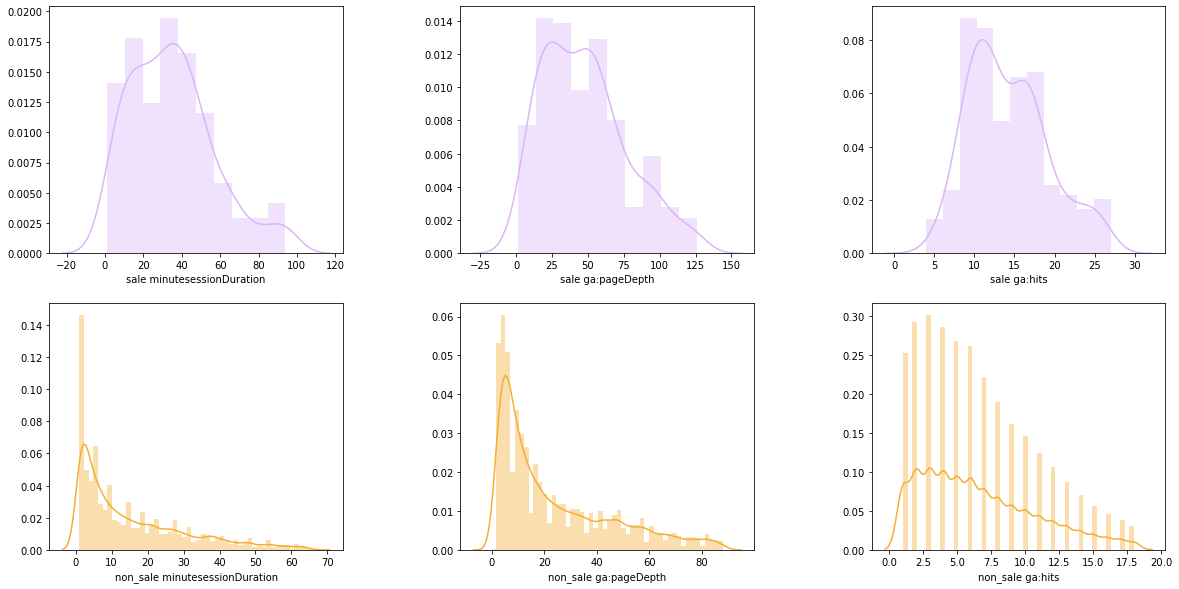

In [54]:
ps_sale_dist,ps_non_sale_dist=Behavior_Dist(df_paidsearch)

In [55]:
two_tables(ps_sale_dist, ps_non_sale_dist)

,Mean,Median,Mode,IQR,12.5th middle,87.5th middle
,,,,,,
sale minutesessionDuration,34.946154,33.000000,39,30.000000,10.000000,62.000000
sale ga:pageDepth,47.703846,46.000000,55,40.250000,15.000000,91.000000
sale ga:hits,14.269231,13.000000,17,7.000000,9.000000,20.000000
,Mean,Median,Mode,IQR,12.5th middle,87.5th middle
,,,,,,
non_sale minutesessionDuration,15.408269,10.000000,1,21.000000,2.000000,36.000000
non_sale ga:pageDepth,23.812408,15.000000,3,30.000000,4.000000,54.000000
non_sale ga:hits,6.571557,6.000000,3,6.000000,2.000000,12.000000


nan


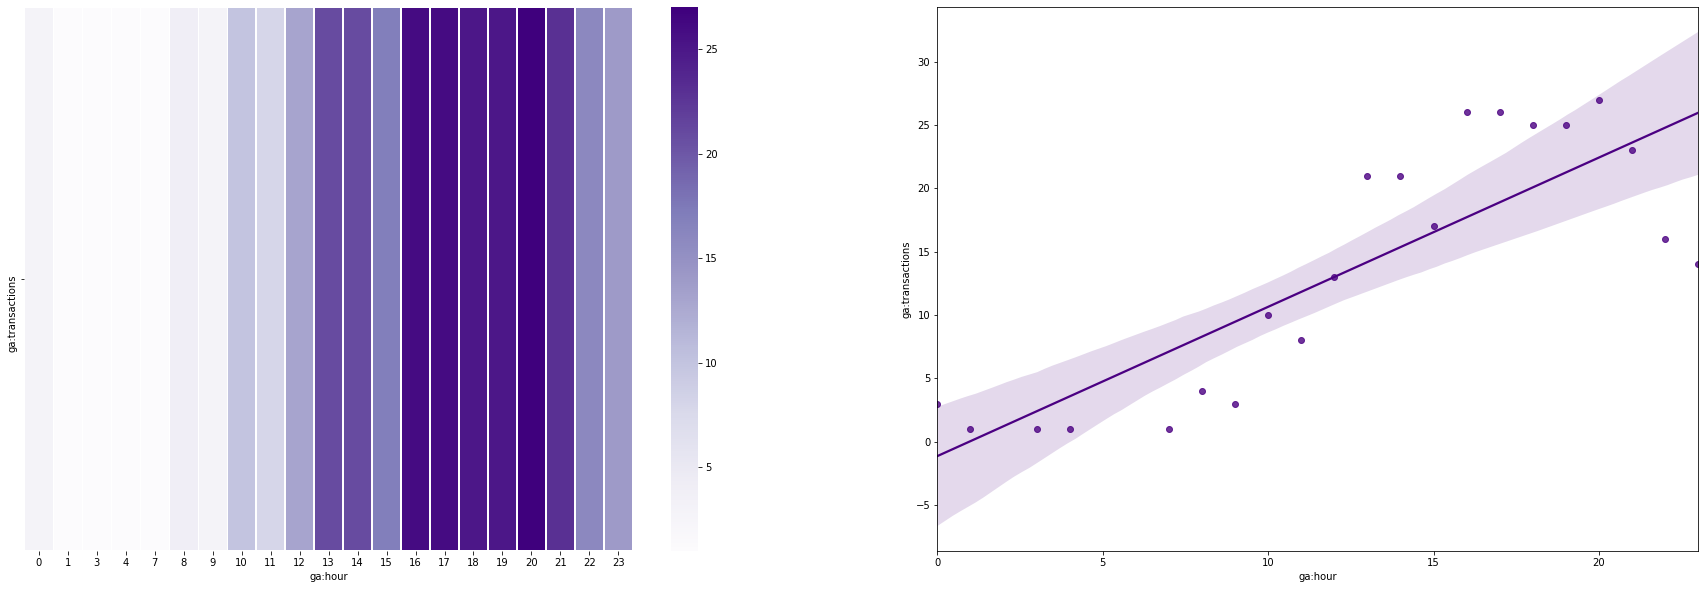

In [56]:
Transaction_Hour_Plot(df_paidsearch)

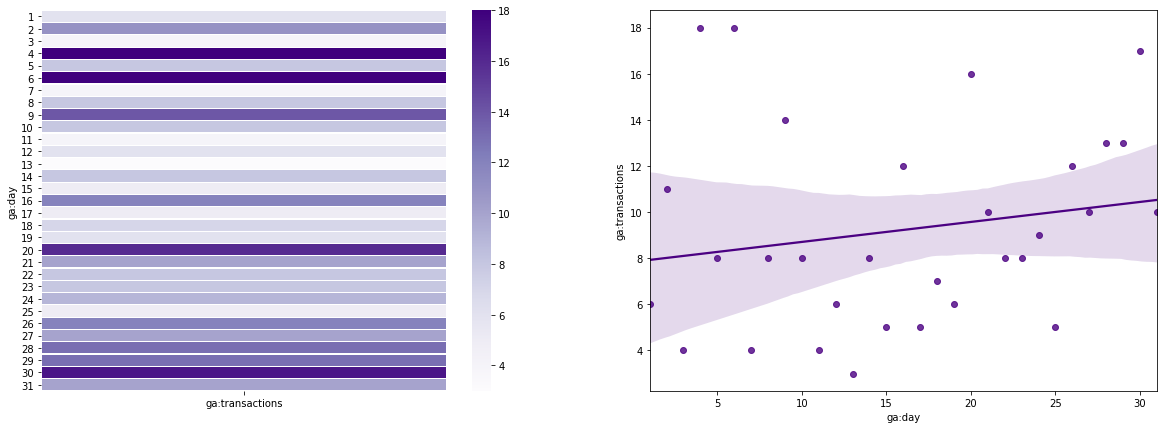

In [57]:
Transactions_Day_Plot(df_paidsearch)

In [58]:
df_paidsearch_p = df_paidsearch.copy()

df_paidsearch_p = Feature_Reduction(df_paidsearch_p)

df_paidsearch_p = pd.get_dummies(df_paidsearch_p)


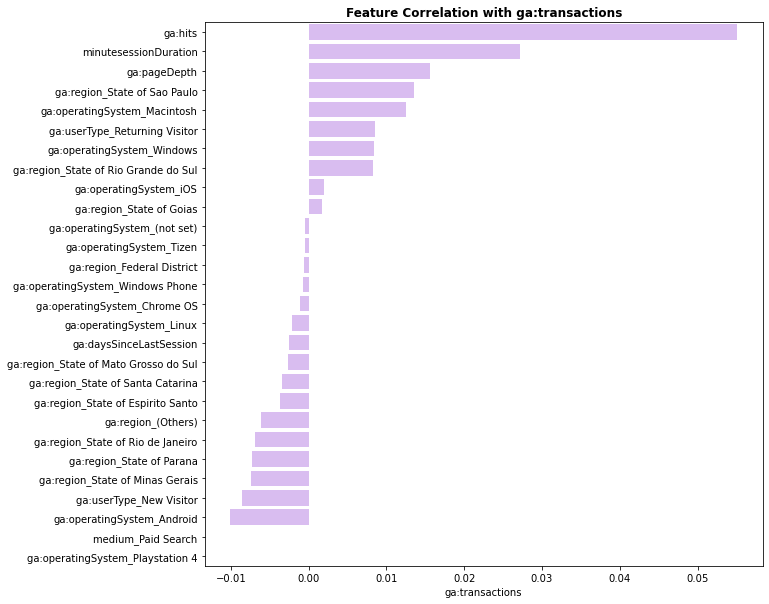

In [59]:
Transaction_Corr(df_paidsearch_p)

## Paidsearch - Summary Overview





**Central Tendency** - In average the **buyers** used to buy 7 items, do 1 transaction per session and the average transaction revenue is 108.82. Total sales of this period is 31,121.57



**Conversion Rate** - Of the 169042 sessions 0.17 % are transactions.



**Buyers Profile** - Most of the **buyers** also used Android and are from São Paulo.



**Distribution of buyer behavior** - The 'MinusteSessionDuration' of the buyers is 39 minutes and the mode of the 'PageDepth' is 55. The middle 75% of **buyers** session used to spend 10.0 and 62 minutes on the site, used to visit between 15.0 and 91 pages on the web site. The **buyers** used to do between 9.0 and 20 hits on the website. 



The middle 75% of **non-buyers** session used to spend 2 and 36 minutes on the site, used to visit between 4 and 54 pages on the web site. The **non-buyers** used to do between 2 and 12 hits on the website. 



The middle 75% speed of **Non-buyers** session are close but smaller than the **buyers** session.



**Transaction Hour** - The higher number of transactions happened between 13h and 21h.



**Transaction Day of the Month** - The number of transactions is spread over the month, but the highest numbers occurred in the first 9 days and the last 11 days.



**Correlations Analysis** -  Hits, minute session duration has the stronger positive correlation. Also we can see that Page Depth and São Paulo,  Macintosh, Returning visitors and Windows are positive correlation as well. 

Again, the stronger negative correlation are Android Operating System and New Visitors.







# Traffic Medium - Direct <a name="direct"></a>

In [60]:
Sales_Central_Tendency(df_direct)

,Mean,Median,Mode,Total
,,,,
ga:itemQuantity,7.64103,5.00,2.00,2086
ga:transactions,1,1.00,1.00,273
ga:transactionRevenue,100.85,68.94,30.96,27530.78


In [61]:
Conversion_Rate(df_direct)

93036 Sessions in this period
Non-transactions 99.71 % 
Transactions 0.29 % 


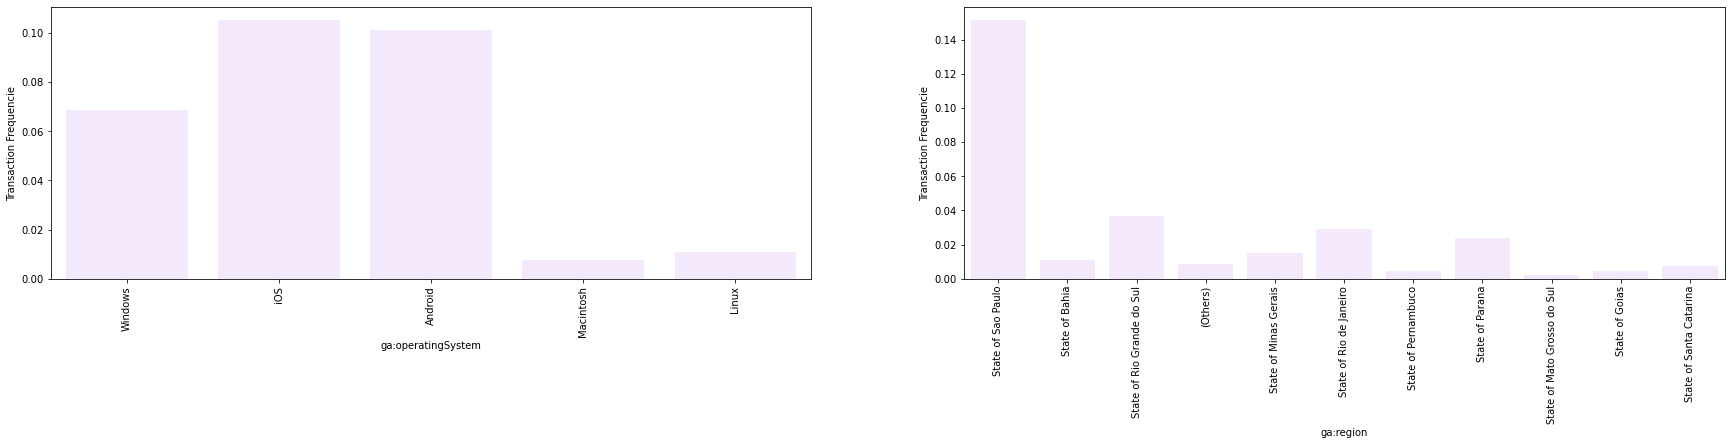

In [62]:
Buyer_Profile(df_direct)

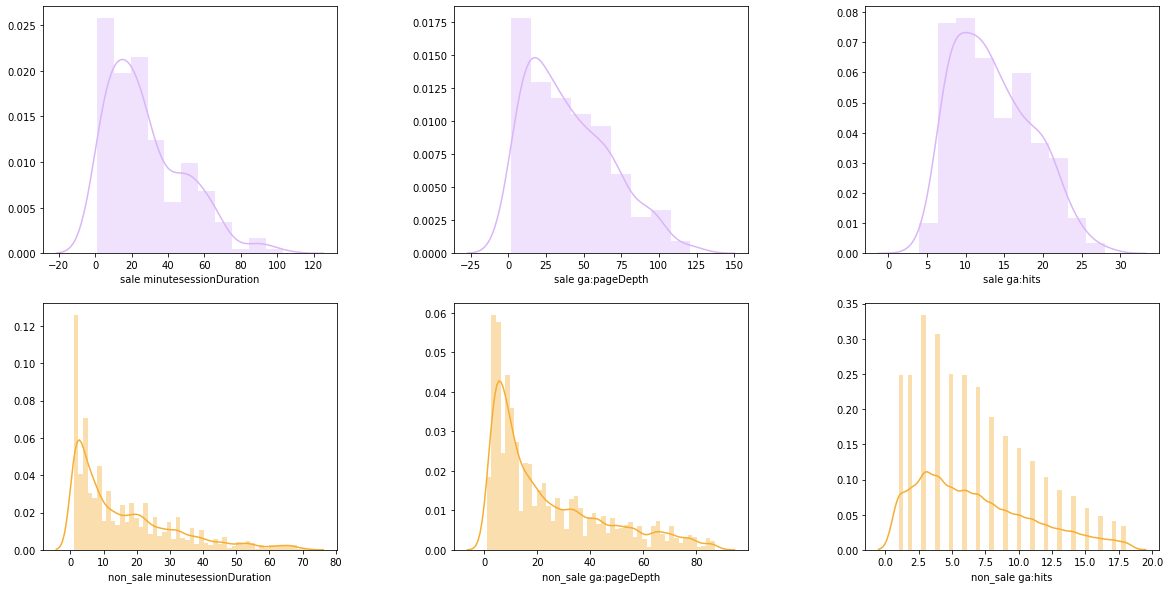

In [63]:
d_sale_dist,d_non_sale_dist = Behavior_Dist(df_direct)

In [64]:
two_tables(d_sale_dist, d_non_sale_dist)

,Mean,Median,Mode,IQR,12.5th middle,87.5th middle
,,,,,,
sale minutesessionDuration,27.796813,22.000000,10,31.500000,5.000000,54.500000
sale ga:pageDepth,40.119522,34.000000,19,42.000000,9.000000,74.250000
sale ga:hits,13.561753,13.000000,8,8.000000,8.000000,20.000000
,Mean,Median,Mode,IQR,12.5th middle,87.5th middle
,,,,,,
non_sale minutesessionDuration,16.047520,11.000000,1,20.000000,2.000000,35.000000
non_sale ga:pageDepth,23.606300,16.000000,5,28.000000,4.000000,53.000000
non_sale ga:hits,6.654826,6.000000,3,6.000000,2.000000,12.000000


nan


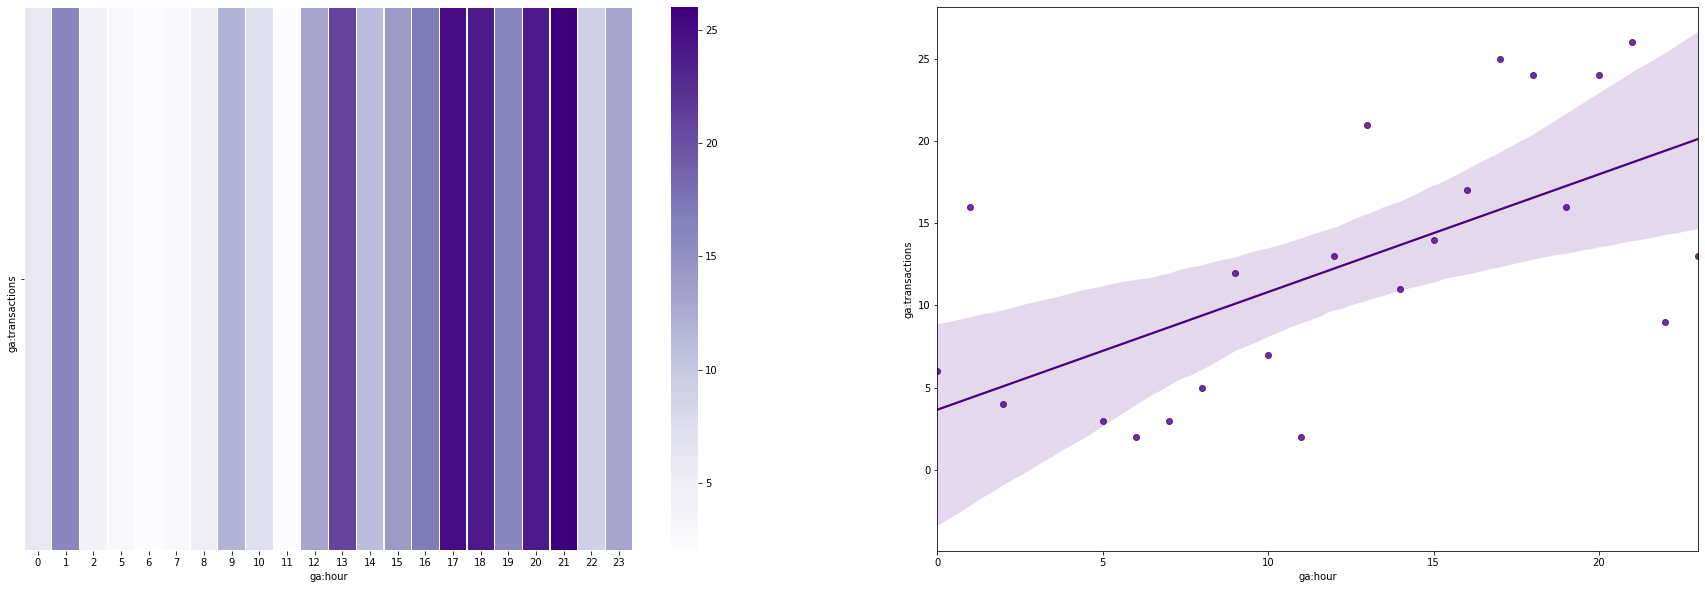

In [65]:
Transaction_Hour_Plot(df_direct)

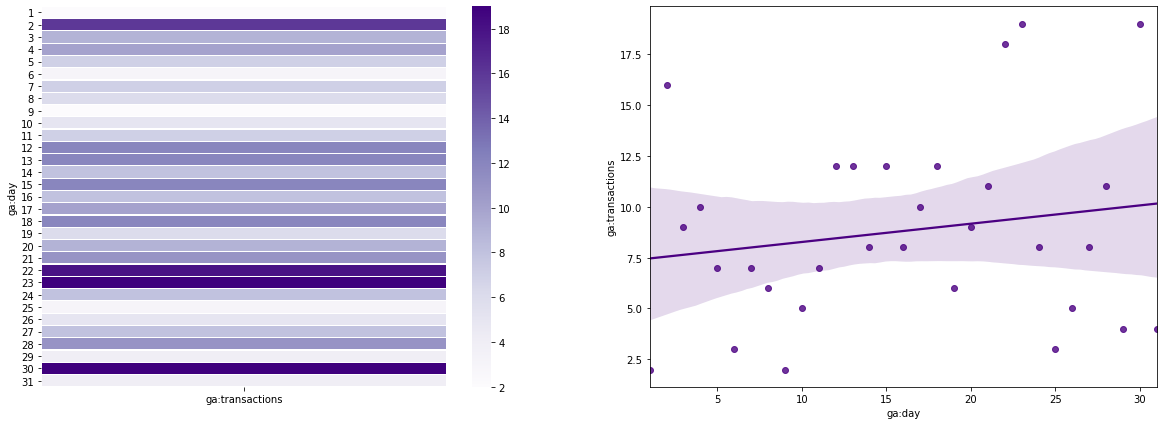

In [66]:
Transactions_Day_Plot(df_direct)

In [67]:
df_direct_p = df_direct.copy()

df_direct_p = Feature_Reduction(df_direct_p)

df_direct_p = pd.get_dummies(df_direct_p)


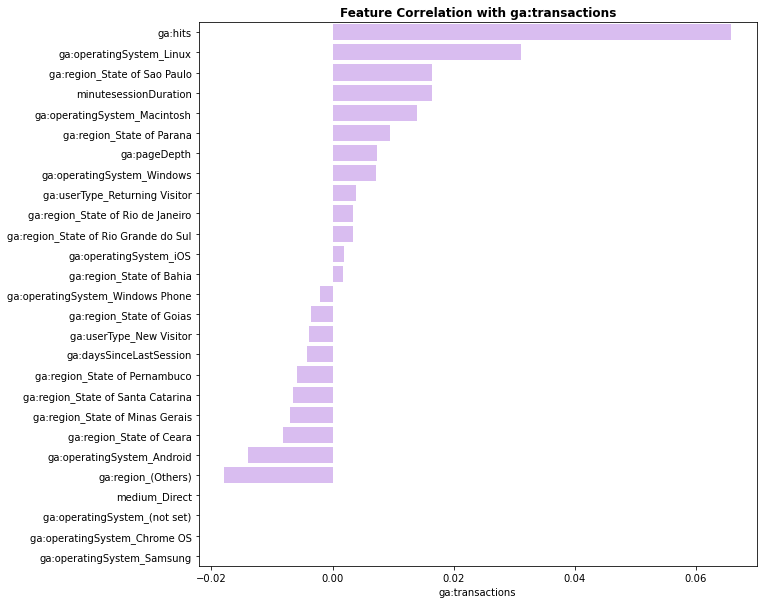

In [68]:
Transaction_Corr(df_direct_p)

## Direct - Summary Overview







**Central Tendency** - In average the **buyers** used to buy 8 items, do 1 transaction per session and the average transaction revenue is 100.85. Total sales of this period is 27,530.78







**Conversion Rate** - Of the 93,036 sessions. 0.29 % are Transactions.







**Buyers Profile** - Most of the **buyers** uses IOS, but almost the same percentage of **buyers** uses Android and the majority are from São Paulo.






**Distribution of buyer behavior** - The mode of **buyers** Hits are 8 and the 'minutesessionDuration' of them are 10. The middle 75% of **buyers** session used to spend 5 and 55.25 minutes on the site, used to visit between 9 and 75 pages on the web site. The **buyers** used to do between 8 and 20 hits on the website. The middle 75% of **Non-buyers** session are close but lower than the **buyers** session.





**Transaction Hour** - The higher number of transactions happened between 13h and 21h.







**Transaction Day of the Month** - The higher number of transactions happened in the second half of the month.







**Correlations Analysis** -  Hits, Linux users have the stronger positive correlation. Also we can see that be from São Paulo, Minute Session Duration, Macintosh Users, be from Paraná and Page Depth are positively correlated as well. 



The stronger negative correlation are users from Others regions and Android users.




# Traffic Medium - Social <a name="social"></a>

In [69]:
Sales_Central_Tendency(df_social)

,Mean,Median,Mode,Total
,,,,
ga:itemQuantity,5.55682,5.00,1.00,978
ga:transactions,1,1.00,1.00,176
ga:transactionRevenue,88.57,71.74,26.68,15587.59


In [70]:
Conversion_Rate(df_social)

114971 Sessions in this period
Non-transactions 99.85 % 
Transactions 0.15 % 


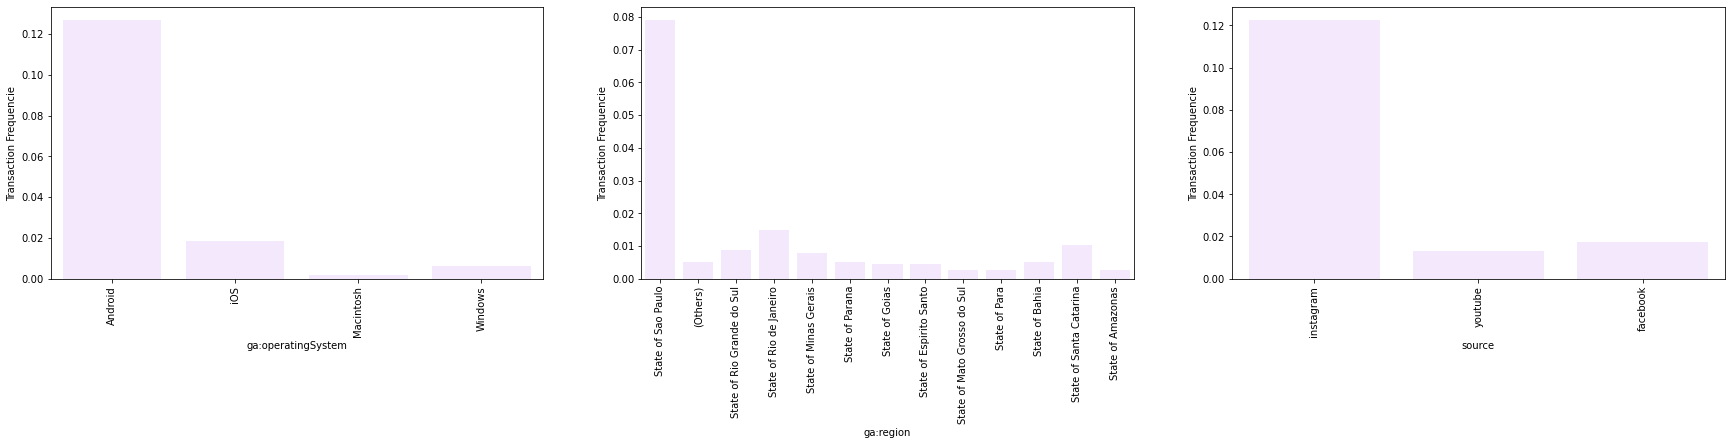

In [71]:
Buyer_Profile(df_social)

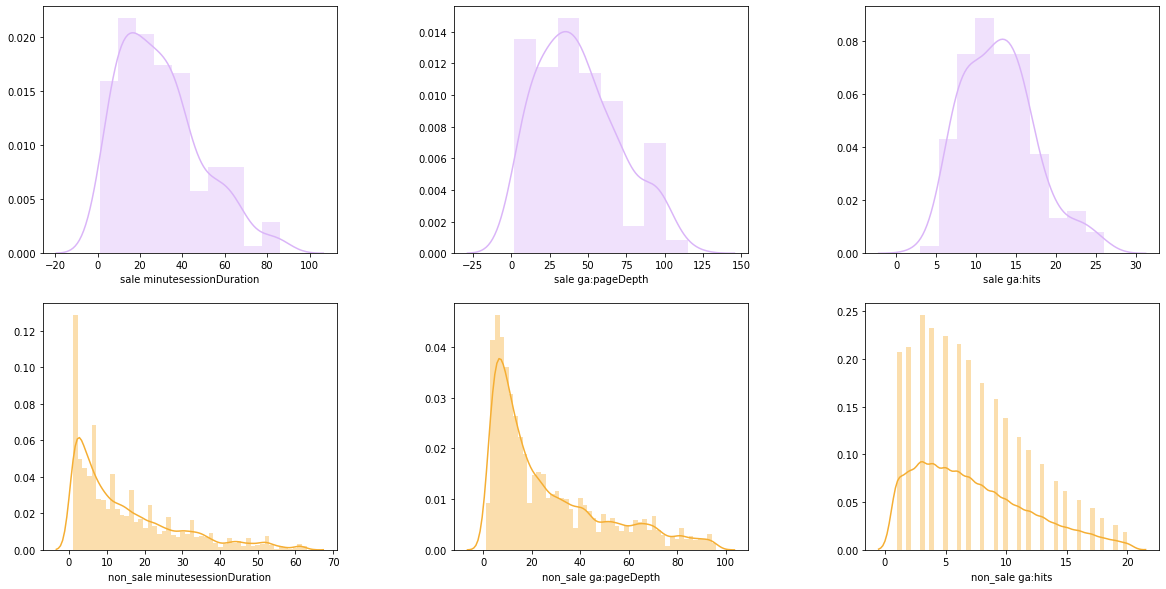

In [72]:
s_sale_dist,s_non_sale_dist = Behavior_Dist(df_social)

In [73]:
two_tables(s_sale_dist, s_non_sale_dist)

,Mean,Median,Mode,IQR,12.5th middle,87.5th middle
,,,,,,
sale minutesessionDuration,29.444444,27.000000,20,24.000000,9.000000,53.875000
sale ga:pageDepth,43.734568,40.000000,11,38.750000,11.000000,74.750000
sale ga:hits,12.820988,13.000000,13,6.750000,8.000000,18.000000
,Mean,Median,Mode,IQR,12.5th middle,87.5th middle
,,,,,,
non_sale minutesessionDuration,14.872014,10.000000,1,18.000000,2.000000,33.000000
non_sale ga:pageDepth,26.276005,17.000000,6,31.000000,5.000000,59.000000
non_sale ga:hits,7.232499,6.000000,3,7.000000,2.000000,13.000000


nan


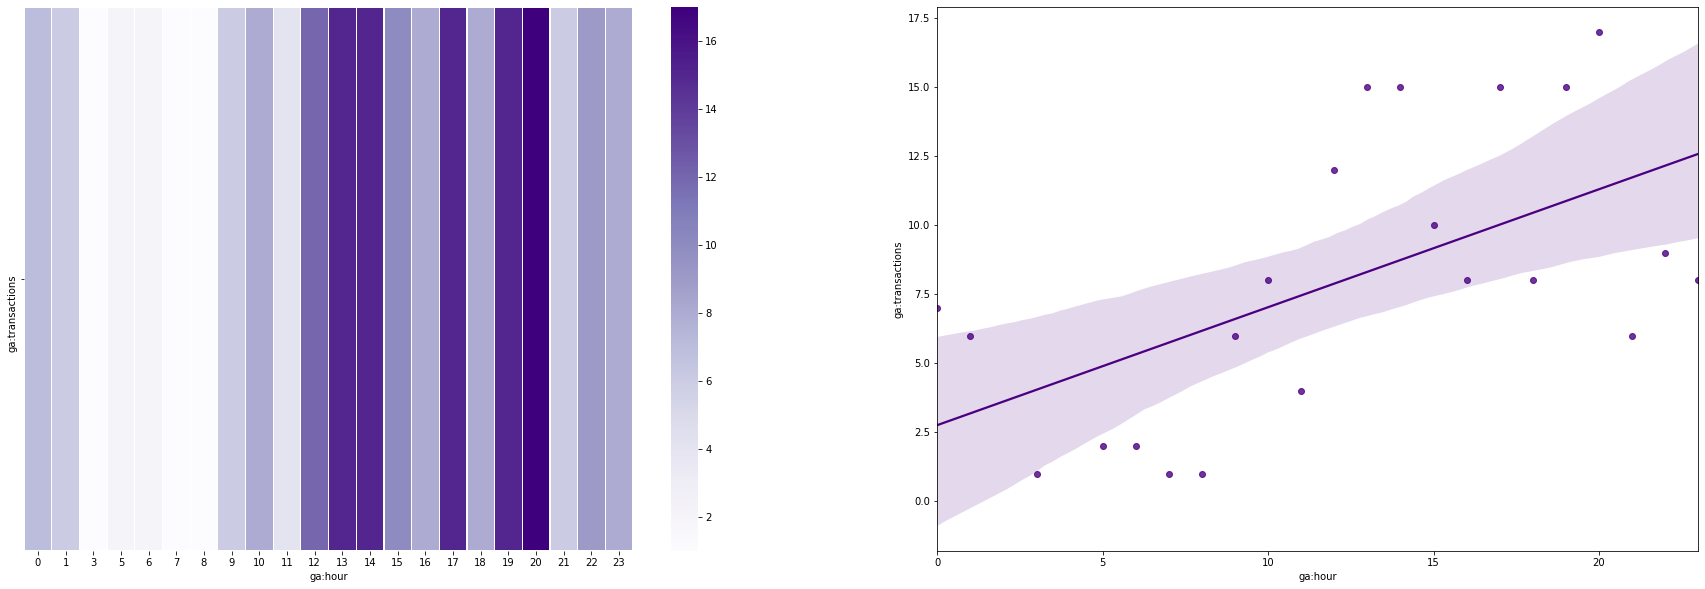

In [74]:
Transaction_Hour_Plot(df_social)

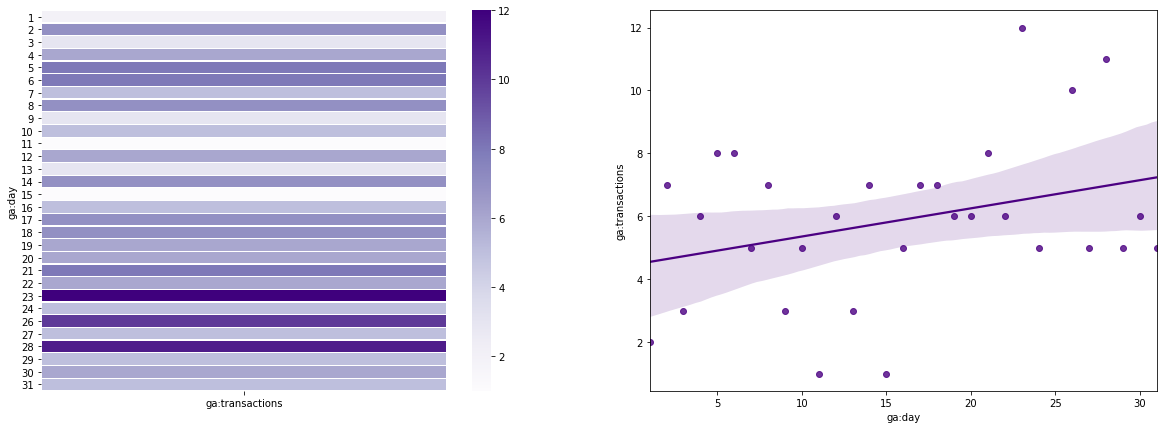

In [75]:
Transactions_Day_Plot(df_social)

In [76]:
df_social_p = df_social.copy()

df_social_p = Feature_Reduction(df_social_p)

df_social_p = pd.get_dummies(df_social_p )


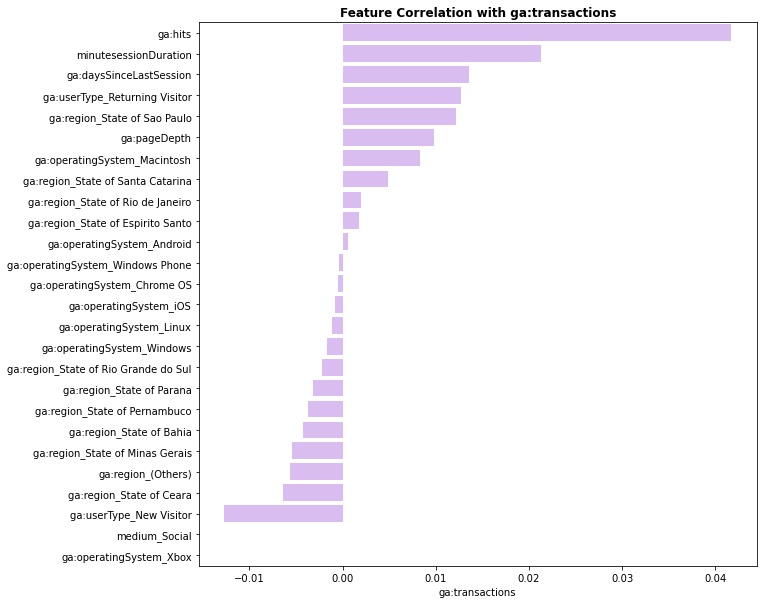

In [77]:
Transaction_Corr(df_social_p )

## Social - Summary Overview





**Central Tendency** - In average the **buyers** used to buy 6 items, do 1 transaction per session and the average transaction revenue is 88.57. Total sales of this period is 15,587.59



**Conversion Rate** - Of the 114,971 sessions, 0.15% are Transactions. 



**Buyers Profile** - Most of the **buyers** used Android and they are from São Paulo and the main source is the Instagram.



**Distribution of buyer behavior** - The middle 75% of **buyers** session used to spend 9.0 and 53 minutes on the site, used to visit between 11.0 and 76.00 pages on the web site. The **buyers** used to do between 8.0 and 18.0 hits on the website. The middle 75% of **Non-buyers** session are close but lower than the **buyers** session.



**Transaction Hour** - The higher number of transactions happened between 12h and 20h.



**Transaction Day of the Month** - The higher number of transactions happened in the second half of the month.

   

**Correlation** - Hits, Minute Session Duration has the stronger negative correlation with the transactions. Days Since Last Session, Returning Visitors, be from São Paulo and PageDepth are positively correlated as well. 
New visitors, users from Ceará and Others regions are negatively correlated with transactions.





# Traffic Medium - (Others) <a name="others"></a>

In [78]:
Sales_Central_Tendency(df_others)

,Mean,Median,Mode,Total
,,,,
ga:itemQuantity,12.8571,5.00,1.00,180
ga:transactions,1,1.00,1.00,14
ga:transactionRevenue,158.82,59.82,35.49,2223.51


**Central Tendency** - In average the buyers used to buy 12 items, do 1 transaction per session and the average transaction revenue is 158.82. Total sales of this period is 2,901.38. The sampling size is too small with just 14 transactions.

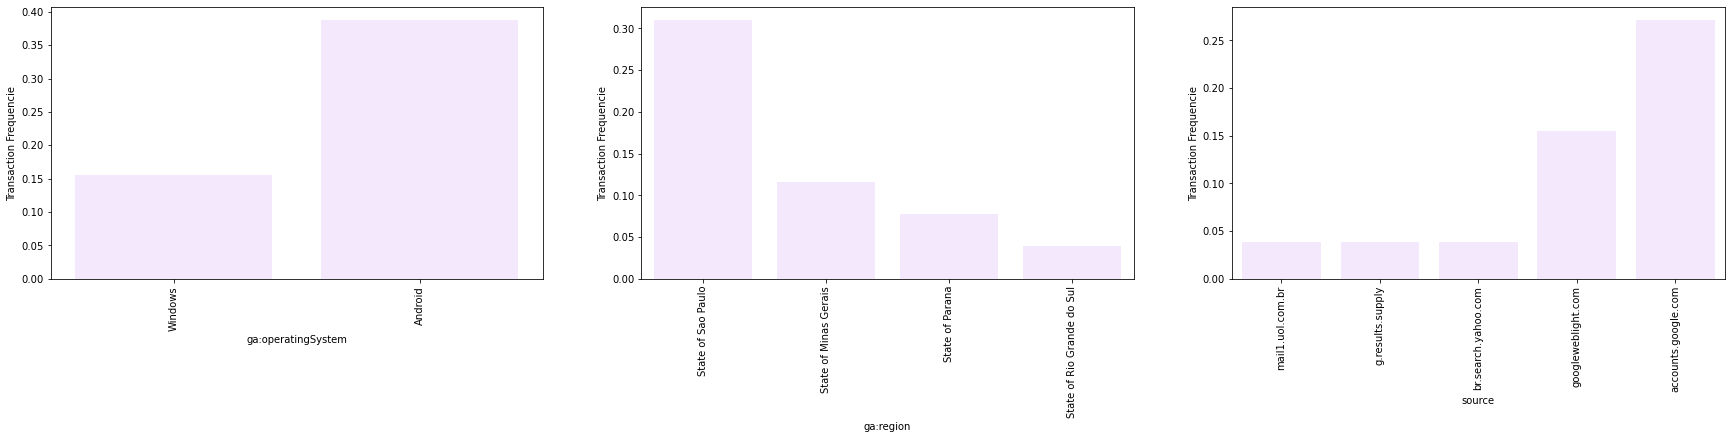

In [79]:
Buyer_Profile(df_others)

**Buyers Profile** - Most of the buyers used Android and they are from São paulo and the main source is the accounts.google.com.(Login functionality via Gmail and where users are redirected to the Google and back to the website.)


# Conclusions  <a name="conclusions"></a>




## Differences & Patterns <a name="dp"></a>






Now that we got the analysis of the full data frame and the analysis per traffic medium we will be able to recognize some patterns and differences between the Full Df and the splitted dataframe.







**Patterns**



- **The central tendency** - The buyers of all traffic mediums used to do 1 transaction per purchase.



- **Conversion Rate** - All data frames are very unbalanced. Where transactions are the minority class.




- **Buyer Profile** - The **buyers** majority are from São Paulo. The difference is the percentile per medium. All the traffic Medium has a very high percentile of Android users. Also we can say that, the buyers used to use mobile devices in most of the mediums.
.


- **Transaction Hour** - The higher number of transactions of all mediums happen in the afternoon and in the night. Between 12h and 22h. Which makes the number of transactions have a strong positive correlation with the hour in all Mediums.



- **Transaction Correlations** -  Hits, Minutes Session Duration, be from São Paulo, Macintosh users or Return Visitors always are in positive correlated with transaction. Also IOS Windows are almost always positively correlated with transactions. The exception is Social Medium. In the other side New visitor, Other regions and Android users are always negative correlated with the transaction.
           





**Difference**







- **The Central Tendency** - In the average of the Full Df the buyers used to buy 6 items per transaction but per medium that has a small variance. **Organic** has the smaller number of items per sale and Direct the higher one 7.64. About revenue, **Paid Search** has the higher ticket 108.82 and Organic the smaller, 86.30.








- **Conversion Rate** - The **Organic** medium brings the most part of the users (186,314). Followed by **Paid Search** (169,042), **Direct** (93,036) and **Social** 114,971. About the conversion rate Direct has the higher one with 0.29%, followed by **Organic** 0.24%, **Paid Search** 0.17% and **Social** 0.15%.








- **Buyer Profile** - The most common Operating System is Android in the majority of the Medium. In the **Direct** medium it changes for a small difference to IOS.





- **Distribution of Buyer and non Buyers Behavior** - Here we can see that all Medium behave differently on the web site. To have an overview and highlight these differences we can look at the mode of buyers per medium. The Minute Session Duration of the Buyers for example, the lower is 10 minutes (**Direct**) and the higher is 39 minutes (**Paid Search**). The modes of the Page Depth are very different in each medium. 7 is the mode number of pages depth for **Organic** and 55 of **Paid Search**. For Hits the difference is also notable, sessions of buyers from **Direct** medium often to do 8 Hits on the site and users from **Paid Search** used to do 17 hits. Another important difference could be noted in the tables in each Traffic Medium session of the netbook but these numbers can prove the point each source medium behaves differently on the website.



- **Transactions Day** -  The **Organic** medium seems to have more transactions in the first half of the month, while the rest of the medium seems to have more transactions in the second half.




- **Transaction Correlations** -As much as we have found some patterns in the transaction correlations, the value of the **PCC** always varies considerably across the mediums.




 



 




## Hypotese Test <a name="ht"></a>

Observing the notebook we can have a good understanding about the behavior of the customers of each traffic medium and find an hypothesis to improve the online experience of the customers. The New Visitors using Android are facing problems. 

It could be proved observing the negative correlation in all mediums. 

We can check that hypothese exploring a bit more the users that have 0 Minute Session Duration.


In [80]:
df[df['minutesessionDuration']==0]['ga:operatingSystem'].value_counts(normalize=True).head()

Android      0.641604
iOS          0.199619
Windows      0.148761
Macintosh    0.005211
Linux        0.003529
Name: ga:operatingSystem, dtype: float64

In [81]:
df[df['minutesessionDuration']==0]['ga:userType'].value_counts(normalize=True).head()

New Visitor          0.952464
Returning Visitor    0.047536
Name: ga:userType, dtype: float64

In [82]:
df[(df['minutesessionDuration']==0)&
   (df['ga:userType']=='New Visitor')]['ga:operatingSystem'].value_counts(normalize=True).head()

Android      0.639722
iOS          0.200940
Windows      0.149220
Macintosh    0.005254
Linux        0.003605
Name: ga:operatingSystem, dtype: float64

In [83]:
df[(df['minutesessionDuration']==0)&
   (df['ga:userType']=='New Visitor')&
   (df['ga:operatingSystem']=='Android')]['ga:region'].value_counts(normalize=True).head()

State of Sao Paulo            0.333234
State of Minas Gerais         0.126483
State of Rio de Janeiro       0.115821
State of Parana               0.064042
State of Rio Grande do Sul    0.059185
Name: ga:region, dtype: float64

We see that 64% of the users which spend less than 1 minute on the website use Android and are New Visitor. Two possible reasons for that are page loading speed and mobile usability of the site. That can be checked with other metrics in Google Analytics.


Improving the experience for that type of user is important because it is very likely that it can increment the revenue. Once the majority of these users (33%) use Android and are from São Paulo. The same buyer profile pattern identified in our Exploratory analysis.


Another approaches that can be suggested t to improve the sales are strategies to increase the number of return visitors to the website. Once the Return Visitors are always positively correlated with the transaction.


## The End <a name="te"></a>





The main idea of this notebook was accomplished. Different insights from Google Analytics API data were gotten and we can also see how different the medium users could be. Also we did find some point to improve on the website that could improve the transactions. 







The information that we got here will be considered in the part II The binary classification (transaction or non transaction session). You can go to the next part clicking [here](https://www.kaggle.com/erickvarela/ga-api-e-commerce-part-ii-classification/) 









That was my first own project and I really wanna know what you guys think about that Exploratory Analysis and I will appreciate any improvement, rewording, criticism feedbacks and an upvote as well.









That's it for now.















Cheers 🍀







[Back to the top](#top)


